# Лабораторная работа №2. Задача классификации

**Тема:** *Анализ и сравнение разных классификаторов*

**Цели:**

- *Научиться обрабатывать датасет*
- *Реализовать разные классификаторы*
- *Понять, как интерпретировать важность признаков (feature importance)*
- *Понять, как увеличивать кол-во признаков (feature tuning)*


**Модели:**

- *Линейная регрессия*
- *Метод опорных векторов (SVM)*
- *$K$ - ближайших соседей*
- *Дерево решений*
- *Случайный лес*
- *Градиентный бустинг*


#### 👋🏻 ЧТО НУЖНО СДЕЛАТЬ СТУДЕНТАМ ???

1. Загрузить датасет, который был в `lr_1.ipynb`
2. Свести его к задаче классификации (бинарной или многоклассовой).
3. Обработать датасет
4. Обучить модели
5. (команда) Реализовать свою логистическую регрессию. Настроить параметр вероятности ответа как if $ y_{pred} < 0,5$ then $0$ else $1$ чтобы получилась бинарная классификация
6. **(необезательно, но можно получить плюсик от меня)** С помощью `optuna` реализовать подгонку гиперпараметров для `CatBoost`.
7. Ответить на вопросы
8. Придумать какую-то уникальность работы, то, что будет вас отличать от других, и это вам надо будет мне "продать".
8. Составить `презентацию` о проделанной работе (10-15 слайдов), а именно: нужно выбрать одну модель, и для нее описать подготовку датасета, распределение данных, показать какие метрики выдает модель при разных настройках, побольше описательных графиков. Вам нужно будет мне "продавть ваше решение".
9. Записать `видео вашей защиты на 5 минут`, где вы рассказываете только о вашей фиче.


## 1. Введение

Цель: загрузить датасет, сделать описание и сформулировать задачу

### 1.0. Испортируем библиотеки и зафиксируем случайность

In [1]:
import os, warnings, inspect
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Try XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

print('HAS_XGB =', HAS_XGB)

HAS_XGB = True


In [2]:
# Project Settings
RANDOM_STATE = 42

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


### 1.1. Загрузка датасета

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_PATH = 'drive/MyDrive/retail/Titanic-Dataset.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'Data file not found: {DATA_PATH}')
df_raw = pd.read_csv(DATA_PATH)
print('Размер датасета:', df_raw.shape)
display(df_raw.head())
print('\nИнфо:')
display(df_raw.info())
print('\nПропуски по столбцам:')
display(df_raw.isnull().sum())

Размер датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Пропуски по столбцам:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Видно, что столбец `Id` не несет никакой смысловой нагрузки

In [6]:
if 'PassengerId' in df_raw.columns:
    df_raw.drop('PassengerId', inplace=True, axis=1)
df_raw.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


### Таблица признаков

| №  | Признак                  | Тип данных     | Описание                                                                               |
| -- | ------------------------ | -------------- | -------------------------------------------------------------------------------------- |
| 1  | **PassengerId**        | int         | Идентификатор пассажира | - удалено
| 2  | **Survived**     | int          | Выжил или нет: 0 = нет, 1 = да     |
| 3  | **Pclass**          | int          | Класс билетов: 1 = 1 -й, 2 = 2 -й, 3 = 3 -й                           |
| 4  | **Name**       | str          | Имя пассажира                        |
| 5  | **Sex**            | str         | Пол              |
| 6  | **Age**  | int          | Возраст в годах                |
| 7  | **SibSp** | int          | Количество родственников / супругов на борту Титаника          |
| 8  | **Parch**              | int          | Количество родителей / детей на борту Титаника                               |
| 9  | **Ticket**                   | float          | Номер билета.                                |
| 10 | **Fare**            | float          | Цена билета  |
| 11 | **Cabin**              |         | Номер кабины                 |
| 12 | **Embarked**    | str | Порт посадки: C = Шербург, Q = Queenstown, S = Southampton                    |

### 1.2. Поставновка задачи

Целевая переменная: `Survived` (0/1). Если бы целевой переменной не было — преобразовать задачу в многоклассовую или бинарную.


## 2. Подготовка данных

### 2.0. Предварительный анализ данных

Типы признаков

In [8]:
print(f'Типы признаков:\n{df_raw.dtypes}')

Типы признаков:
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object


В датасете все признаки имеют тип `float64`, только целевая переменная имеет тип `int64`.

In [9]:
print(f'Пропуски данных:\n{df_raw.isna().sum()}')

Пропуски данных:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


нужно будет избавиться от пропусков

In [10]:
# Рабочая копия
df_proc = df_raw.copy()

# Удаляем столбцы с высоким кардиналом (Name, Ticket, Cabin) как в типичном примере
for c in ['Name','Ticket','Cabin']:
    if c in df_proc.columns:
        df_proc.drop(columns=c, inplace=True)

# Логарифм тарифа для уменьшения влияния выбросов
df_proc['Fare'] = df_proc['Fare'].fillna(0)
df_proc['Fare_log'] = np.log1p(df_proc['Fare'])

# Возраст — заполнение медианой
df_proc['Age'] = df_proc['Age'].fillna(df_proc['Age'].median())

# Категориальные: небольшая проверка 'Embarked' пропусков
if 'Embarked' in df_proc.columns:
    print('Embarked unique:', df_proc['Embarked'].unique())
    df_proc['Embarked'] = df_proc['Embarked'].fillna(df_proc['Embarked'].mode()[0])

print('После FE: shape=', df_proc.shape)
display(df_proc.head())

Embarked unique: ['S' 'C' 'Q' nan]
После FE: shape= (891, 9)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_log
0,0,3,male,22.0,1,0,7.2500,S,2.110213
1,1,1,female,38.0,1,0,71.2833,C,4.280593
2,1,3,female,26.0,0,0,7.9250,S,2.188856
3,1,1,female,35.0,1,0,53.1000,S,3.990834
4,0,3,male,35.0,0,0,8.0500,S,2.202765


In [11]:
print('Базовая статистика в удобном виде:')
df_raw.describe().T

Базовая статистика в удобном виде:


,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


По базовой статистике видно, что у некоторых фичей есть скос и выбросы.

### 2.1. Feauture Engineering

Признак размера семьи

In [12]:
# Размер семьи
df_raw['FamilySize'] = df_raw['SibSp'] + df_raw['Parch'] + 1

# Один или нет
df_raw['IsAlone'] = (df_raw['FamilySize'] == 1).astype(int)

df_raw[['FamilySize', 'IsAlone']].head(4)

,FamilySize,IsAlone
0,2,0
1,2,0
2,1,1
3,2,0


Извлечение титула из имени

In [15]:
df_full = pd.read_csv('drive/MyDrive/retail/Titanic-Dataset.csv')
df_raw['Title'] = df_full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_raw['Title'] = df_raw['Title'].replace(['Mlle', 'Ms'], 'Miss')
df_raw['Title'] = df_raw['Title'].replace(['Mme'], 'Mrs')
df_raw['Title'] = df_raw['Title'].replace(['Dr', 'Major', 'Col', 'Rev', 'Capt', 'Countess', 'Lady', 'Sir', 'Jonkheer', 'Don'], 'Rare')

df_raw['Title'].head(4)


,Title
0,Mr
1,Mrs
2,Miss
3,Mrs


Добавим соотношение cтоимостb на человека

In [16]:
df_raw['FarePerPerson'] = df_raw['Fare'] / df_raw['FamilySize']

df_raw[['FarePerPerson', 'Fare', 'FamilySize']].head(4)

,FarePerPerson,Fare,FamilySize
0,3.62500,7.2500,2
1,35.64165,71.2833,2
2,7.92500,7.9250,1
3,26.55000,53.1000,2


Добавим так же фичу отношения возраста на класс

In [17]:
df_raw['AgeClass'] = df_raw['Age'] * df_raw['Pclass']

df_raw[['AgeClass', 'Age', 'Pclass']].head(4)

,AgeClass,Age,Pclass
0,66.0,22.0,3
1,38.0,38.0,1
2,78.0,26.0,3
3,35.0,35.0,1


Кодирование категориальных переменных

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
le = LabelEncoder()
df_raw['Sex_Code'] = le.fit_transform(df_raw['Sex'])
df_raw['Embarked_Code'] = le.fit_transform(df_raw['Embarked'])
df_raw['Title_Code'] = le.fit_transform(df_raw['Title'])

Модели типа линейной регрессии не улавливают взаимодействия, а деревья могут делать это неэффективно. Явное их кодирование очень помогает.

Взаимодействие пола и класса

In [20]:
df_raw['Sex_Pclass'] = df_raw['Sex_Code'] * df_raw['Pclass']

df_raw[['Sex_Pclass', 'Sex_Code', 'Pclass']].head(4)

,Sex_Pclass,Sex_Code,Pclass
0,3,1,3
1,0,0,1
2,0,0,3
3,0,0,1


Добавим еще несколько квадратичных фич

In [21]:
df_raw['Age_squared'] = df_raw['Age'] ** 2
df_raw['Age_sqrt'] = df_raw['Age'] ** 0.5

# Взаимодействие: класс * стоимость билета
df_raw['Class_Fare'] = df_raw['Pclass'] * df_raw['Fare']

# Логарифм стоимости билета (сглаживает выбросы)
df_raw['Fare_log'] = np.log1p(df_raw['Fare'])

df_raw[['Age_squared', 'Age_sqrt', 'Class_Fare', 'Fare_log']].head(4)

,Age_squared,Age_sqrt,Class_Fare,Fare_log
0,484.0,4.690416,21.7500,2.110213
1,1444.0,6.164414,71.2833,4.280593
2,676.0,5.099020,23.7750,2.188856
3,1225.0,5.916080,53.1000,3.990834


Итого у нас получилось (24 фичи)

In [22]:
df_raw.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FarePerPerson,AgeClass,Sex_Code,Embarked_Code,Title_Code,Sex_Pclass,Age_squared,Age_sqrt,Class_Fare,Fare_log
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,3.62500,66.0,1,2,2,3,484.0,4.690416,21.7500,2.110213
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,35.64165,38.0,0,0,3,0,1444.0,6.164414,71.2833,4.280593
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,7.92500,78.0,0,2,1,0,676.0,5.099020,23.7750,2.188856


In [23]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.0,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.0,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.0,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.0,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.0,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200
FamilySize,891.0,1.904602,1.613459,1.000000,1.000000,1.000000,2.000000,11.000000
IsAlone,891.0,0.602694,0.489615,0.000000,0.000000,1.000000,1.000000,1.000000
FarePerPerson,891.0,19.916375,35.841257,0.000000,7.250000,8.300000,23.666667,512.329200
AgeClass,714.0,61.938151,34.379609,0.920000,38.000000,58.000000,81.000000,222.000000


### 2.2. Предобработка данных

#### 2.2.0 Сведение к задачи бинарной классификации

Создадим новую целевую метку для задачи **бинарной** классификации `Is_Survived`, т.к. $survived \in \{0, 1\}$, то будем считать человека выжившим, если $Survived = 1$.

In [24]:
df_raw['Survived'] = (df_raw['Survived'] == 1).astype(np.int64)
df_raw['Survived'].head(4)

,Survived
0,0
1,1
2,1
3,1


#### 2.3.1. Создадим копию данных `df_lin` для линейной `классификации`, `KNN`, `SVM`, `df_raw` оставим для бустинга и деревьев 😸

In [25]:
df_lin = df_raw.copy()

In [66]:
# Проверка целевой переменной
print('y unique values:', df_proc['Survived'].unique())
print(df_proc['Survived'].value_counts(dropna=False))
print('dtype:', df_proc['Survived'].dtype)


y unique values: [0 1]
Survived
0    549
1    342
Name: count, dtype: int64
dtype: int64


In [67]:
# 0) Убедимся, что работаем с нужным DataFrame
df_proc = df_proc.copy()   # рабочая копия (не рушим оригинал)

# 1) Проверка и очистка целевой переменной
# Удаляем строки с пустым таргетом и приводим к int
df_proc = df_proc.dropna(subset=['Survived'])
df_proc['Survived'] = df_proc['Survived'].astype(int)

print('Target distribution (Survived):')
print(df_proc['Survived'].value_counts())
print(df_proc['Survived'].dtype)

# 2) Удаляем высококардинальные текстовые колонки, если они остались
for c in ['Name', 'Ticket', 'Cabin']:
    if c in df_proc.columns:
        df_proc.drop(columns=c, inplace=True)

# 3) Формируем X и y на основе df_proc (только после всех FE/очисток)
X = df_proc.drop(columns=['Survived'])
y = df_proc['Survived']

# 4) Разделяем на train/test (стратифицировано по y)
from sklearn.model_selection import train_test_split, StratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Проверка: в train и test должно быть оба класса
print('Train target counts:\n', y_train.value_counts())
print('Test target counts:\n', y_test.value_counts())

# 5) Определяем числовые и категориальные колонки на основе X (НЕ включая target)
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print('num_cols =', num_cols)
print('cat_cols =', cat_cols)

# 6) Пайплайны для трансформаций (совместимы с разными версиями sklearn)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import inspect

num_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

sig = inspect.signature(OneHotEncoder.__init__)
if 'sparse' in sig.parameters:
    ohe_kwargs = {'sparse': False}
else:
    ohe_kwargs = {'sparse_output': False}

cat_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', **ohe_kwargs))
])

# Если нет категорий или нет чисел — ColumnTransformer должен всё же корректно работать.
transformers = []
if len(num_cols) > 0:
    transformers.append(('num', num_transform, num_cols))
if len(cat_cols) > 0:
    transformers.append(('cat', cat_transform, cat_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# 7) Применяем препроцессор (fit только на train)
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

print('X_train_p shape:', getattr(X_train_p, 'shape', None), 'X_test_p shape:', getattr(X_test_p, 'shape', None))


Target distribution (Survived):
Survived
0    549
1    342
Name: count, dtype: int64
int64
Train target counts:
 Survived
0    439
1    273
Name: count, dtype: int64
Test target counts:
 Survived
0    110
1     69
Name: count, dtype: int64
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log']
cat_cols = ['Sex', 'Embarked']
X_train_p shape: (712, 11) X_test_p shape: (179, 11)


In [68]:
print(df_proc['Survived'].value_counts())
print('X_train shape, X_test shape:', X_train.shape, X_test.shape)
print('X_train_p shape, X_test_p shape:', X_train_p.shape, X_test_p.shape)


Survived
0    549
1    342
Name: count, dtype: int64
X_train shape, X_test shape: (712, 8) (179, 8)
X_train_p shape, X_test_p shape: (712, 11) (179, 11)


#### 2.3.2. Создание методов для отрисовки и обработки данных

Корреляционная матрица

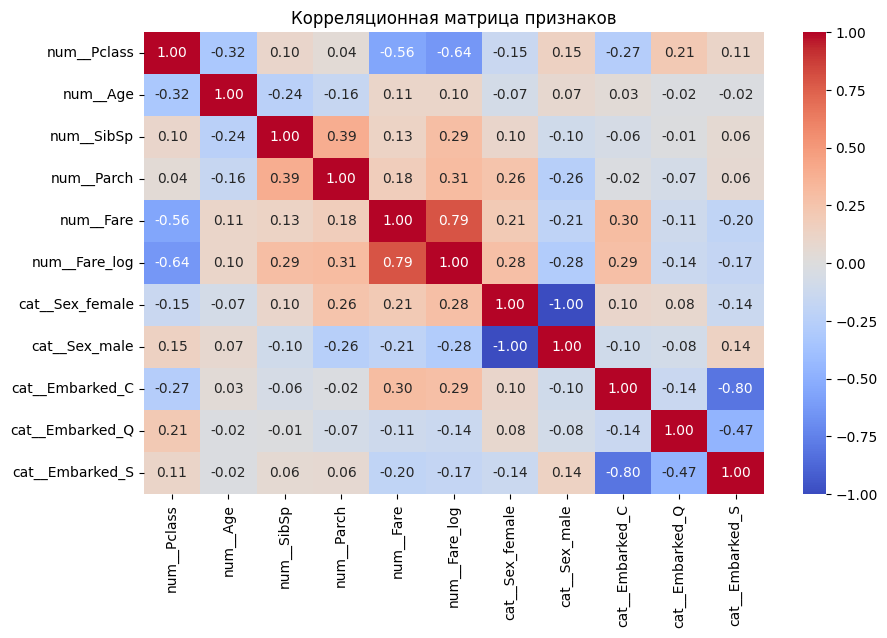

In [27]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Корреляционная матрица признаков")
    plt.show()

# example
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_p, columns=feature_names)
draw_corr_matrix(X_train_df)

Гистограмма распределения

In [28]:
import math

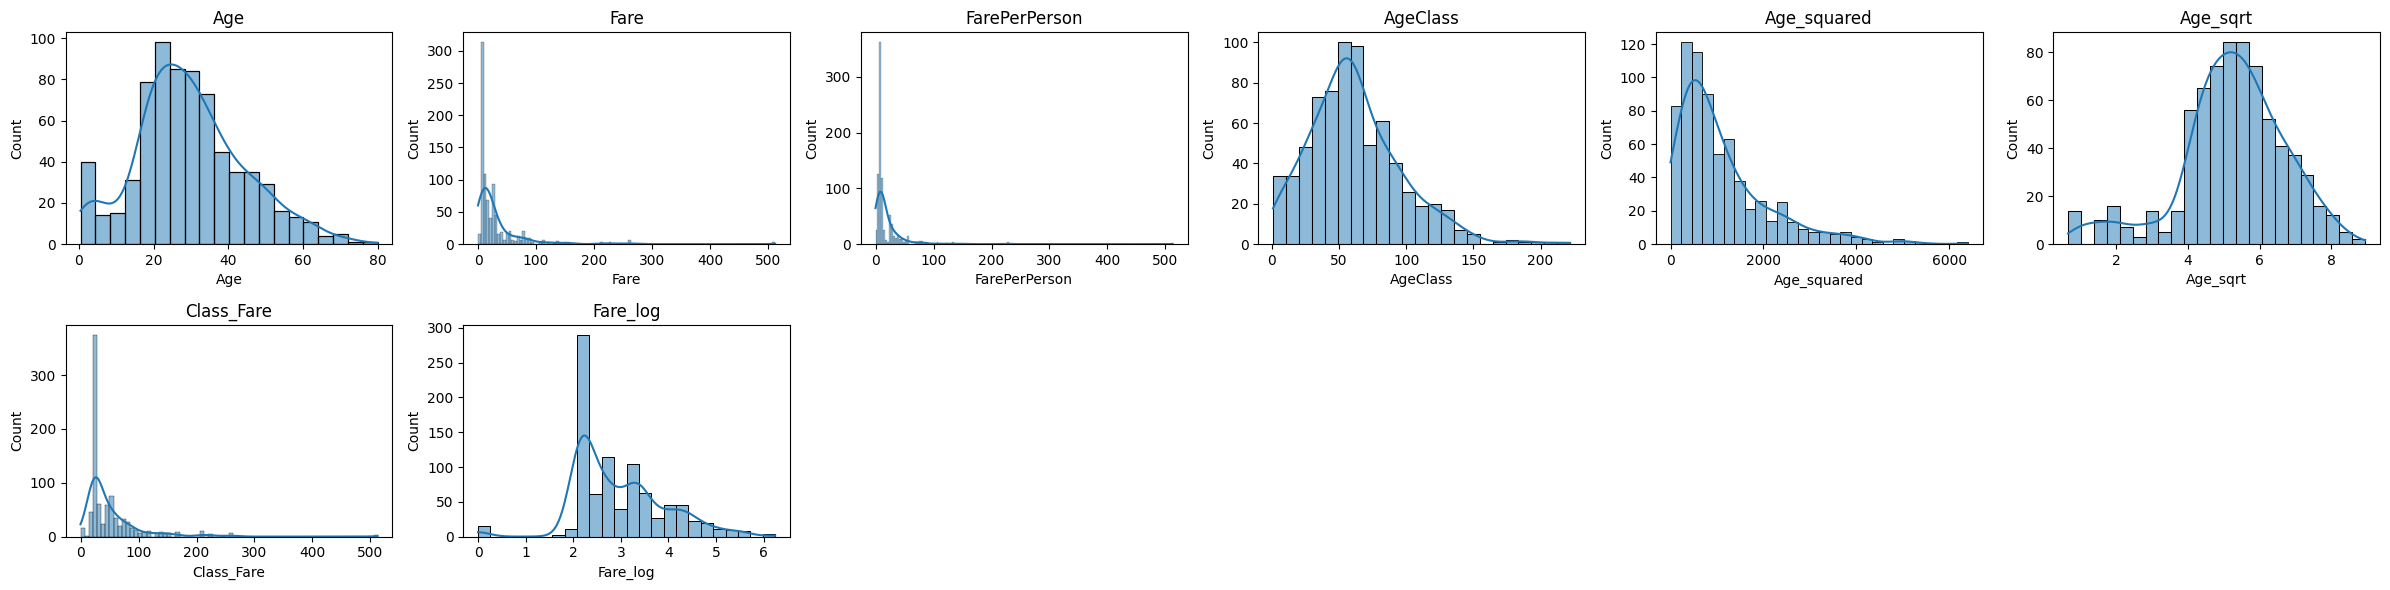

In [29]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(df_lin)

Соотношение с целевой переменной + коэфициент пирсона

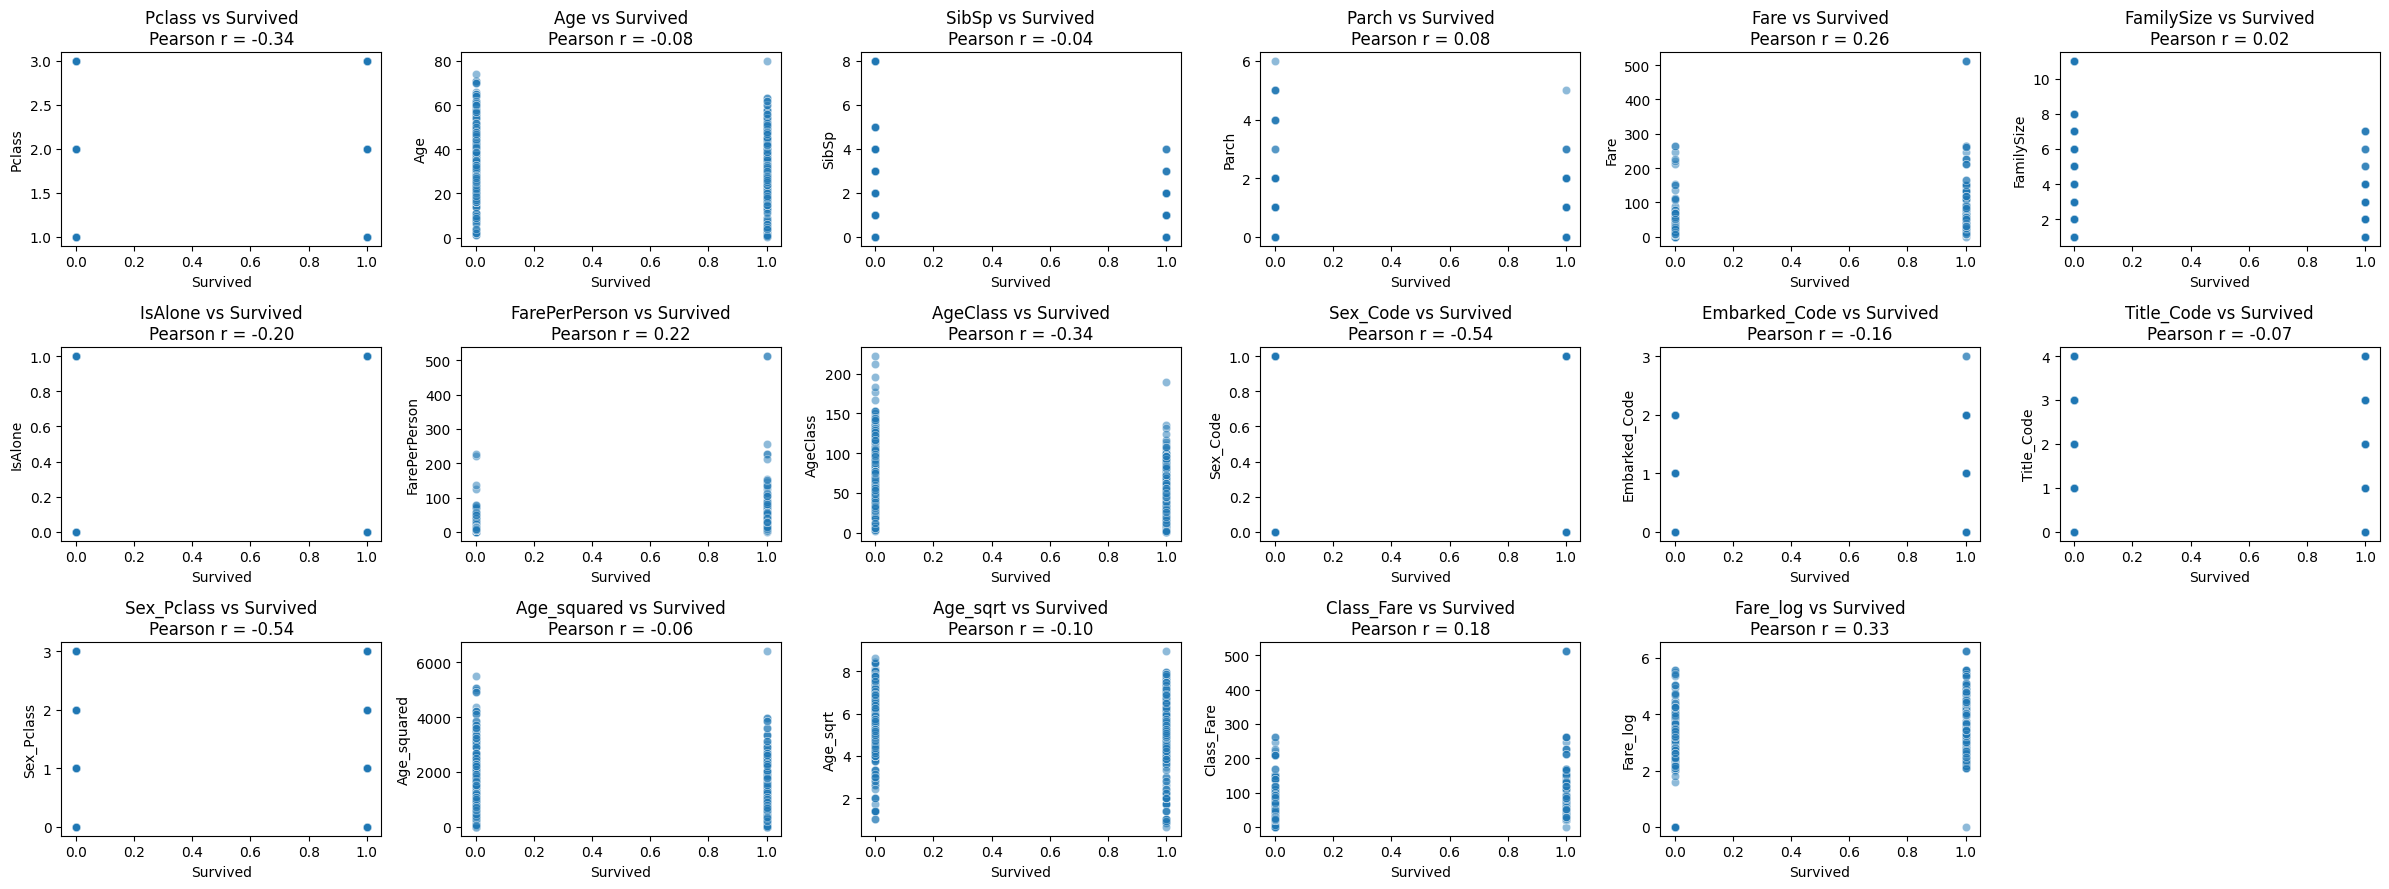

In [30]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(df_lin, target="Survived")

Ящик с усами

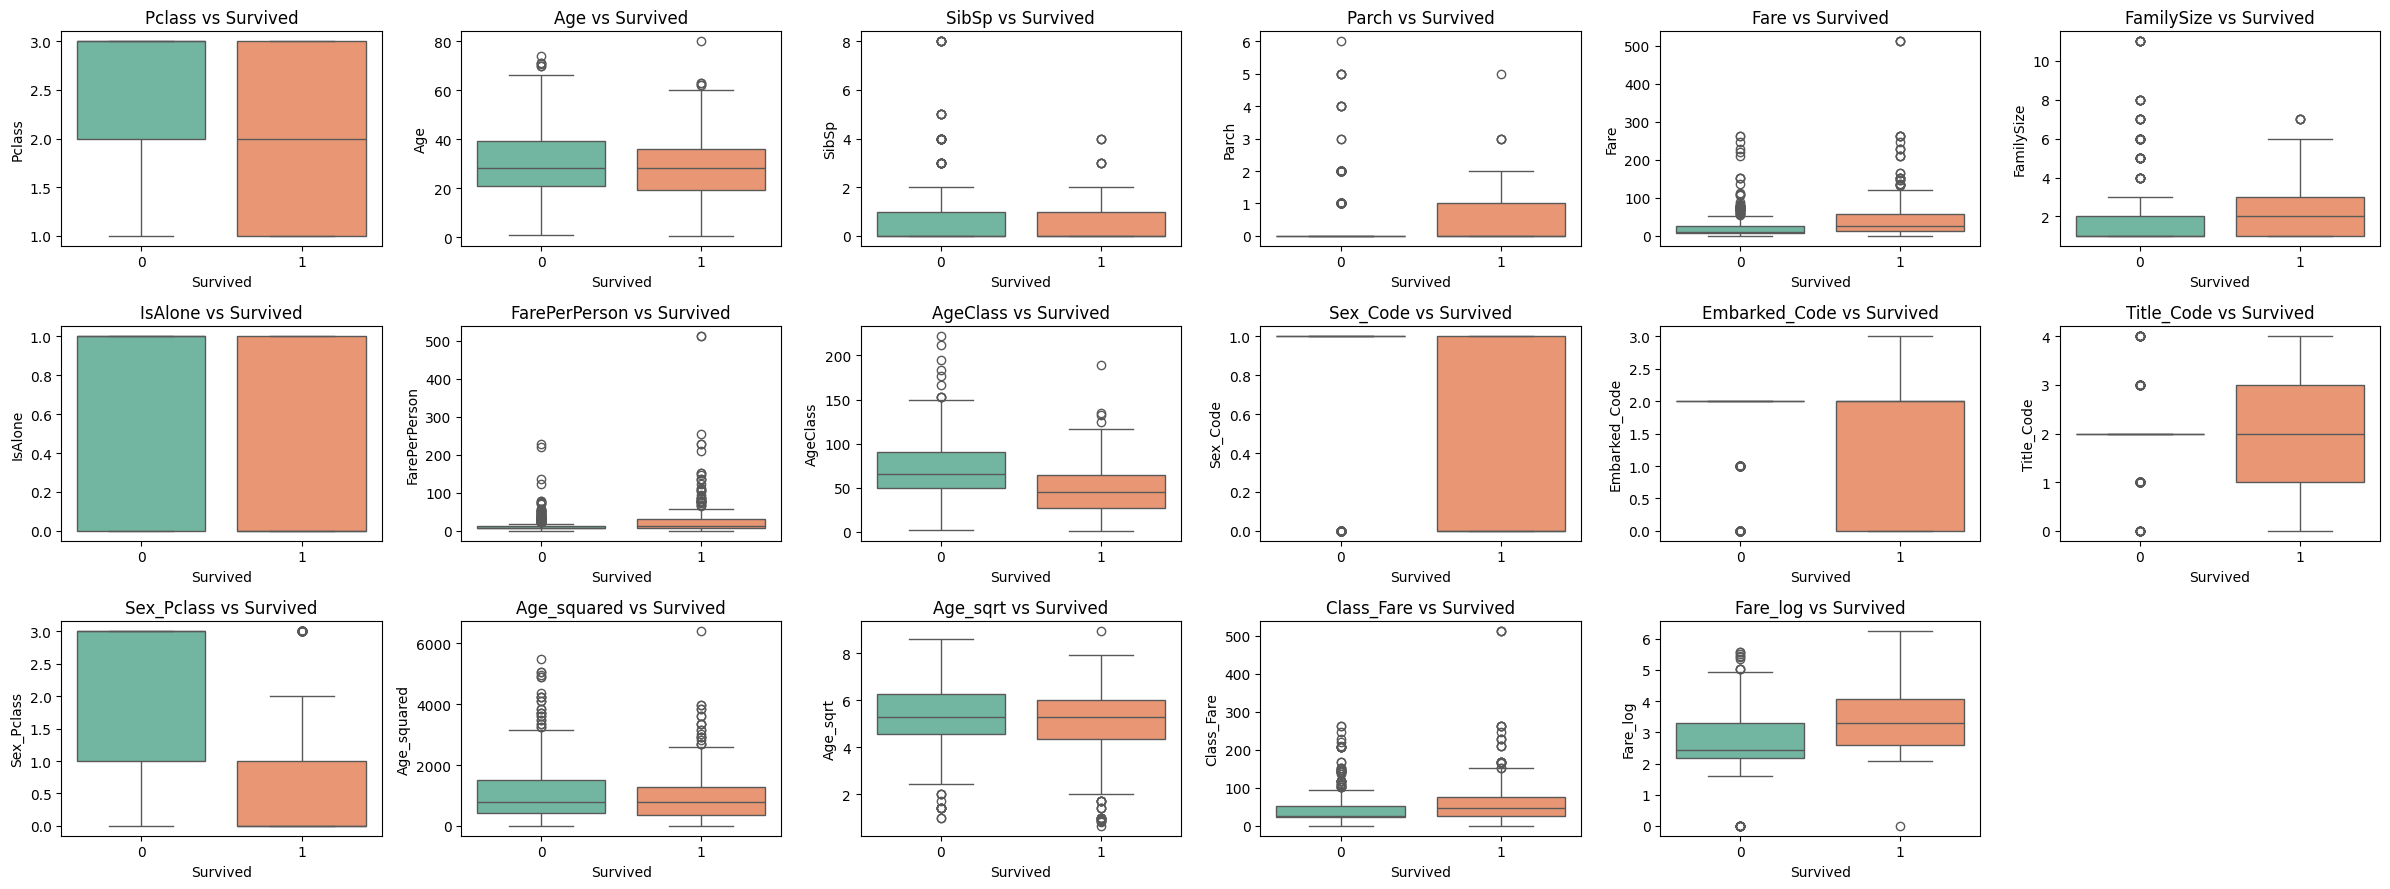

In [31]:
def draw_boxplots(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.boxplot(
            x=target, y=col, data=df, ax=axs[i],
            hue=target, palette="Set2", legend=False
        )
        axs[i].set_title(f'{col} vs {target}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_boxplots(df_lin, target="Survived")

Удаление выбросов

In [32]:
# обработка выбросов
def remove_outliers_iqr(df, columns, low, high):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(low)
        Q3 = df_clean[col].quantile(high)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

Подготовка правых скосов

In [33]:
# обработка скосов
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

#### 2.3.3. Посмотрим на выбросы переменных

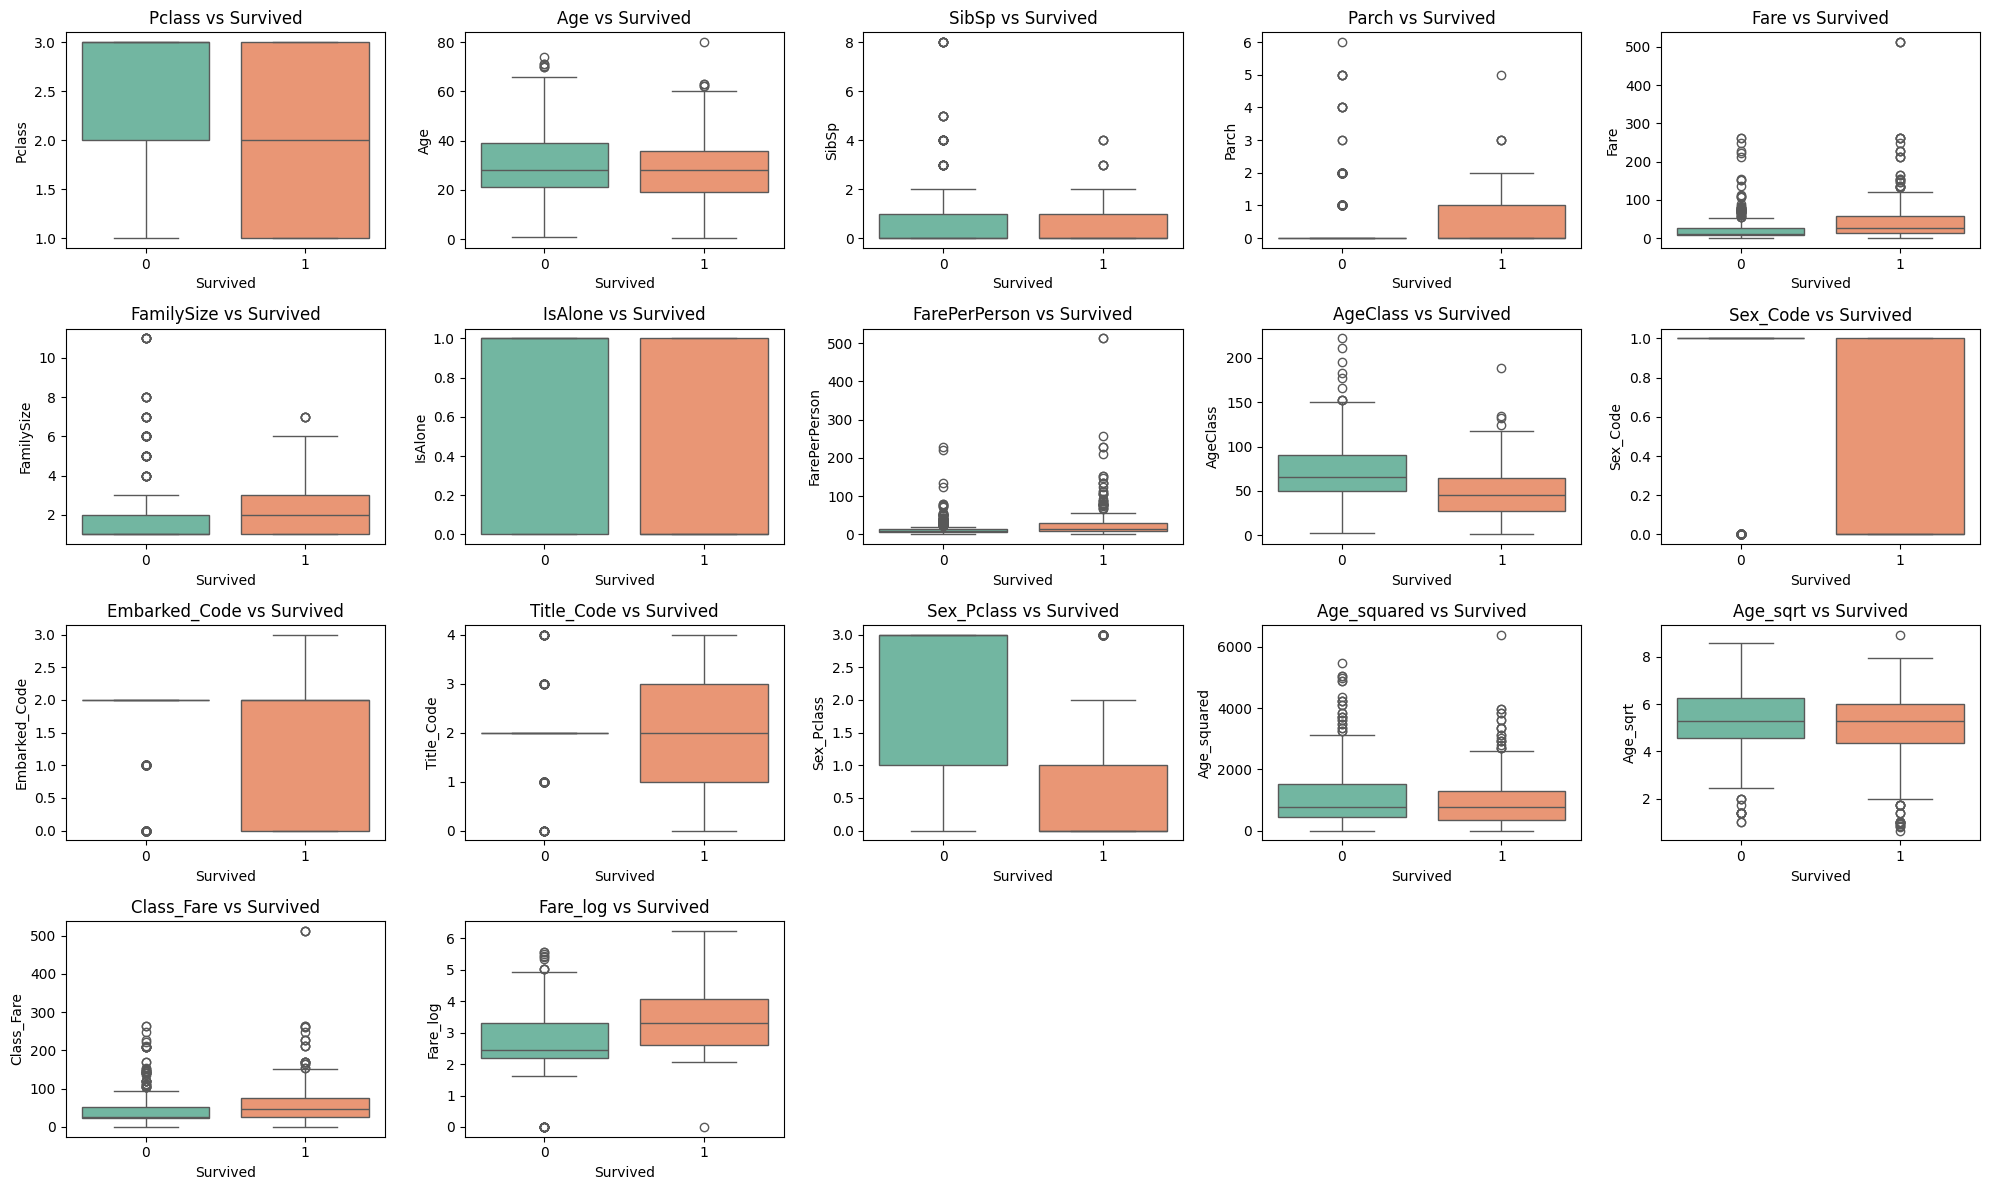

In [34]:
draw_boxplots(df_lin, 'Survived', n_cols=5)

Удалим выбросы

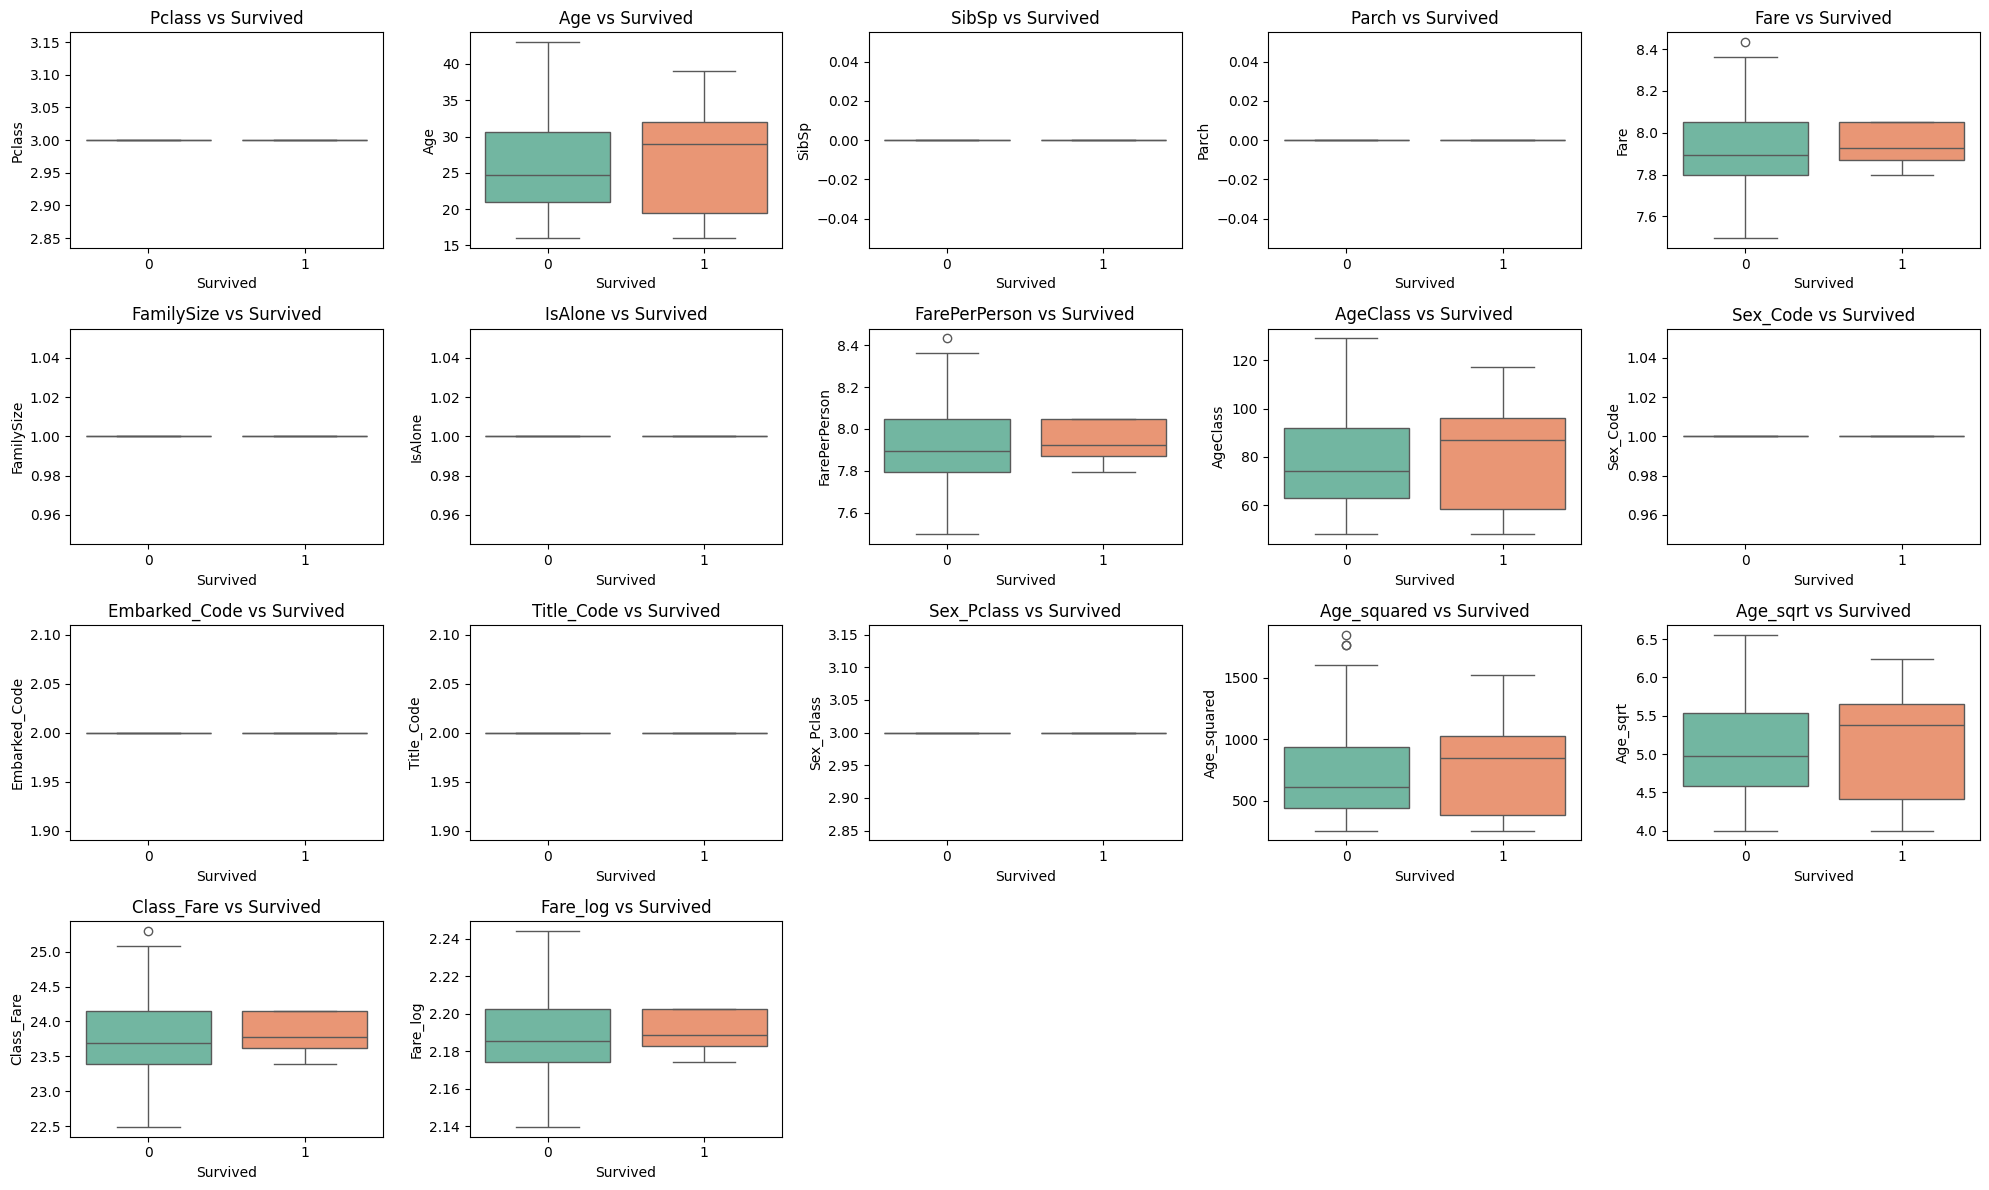

In [35]:
df_lin = remove_outliers_iqr(df_lin, df_lin.select_dtypes(include=['float', 'int']).columns.drop('Survived'), 0.25, 0.75)
draw_boxplots(df_lin, 'Survived', n_cols=5)

#### 2.3.4. Посмотрим на скошенные столбцы справа

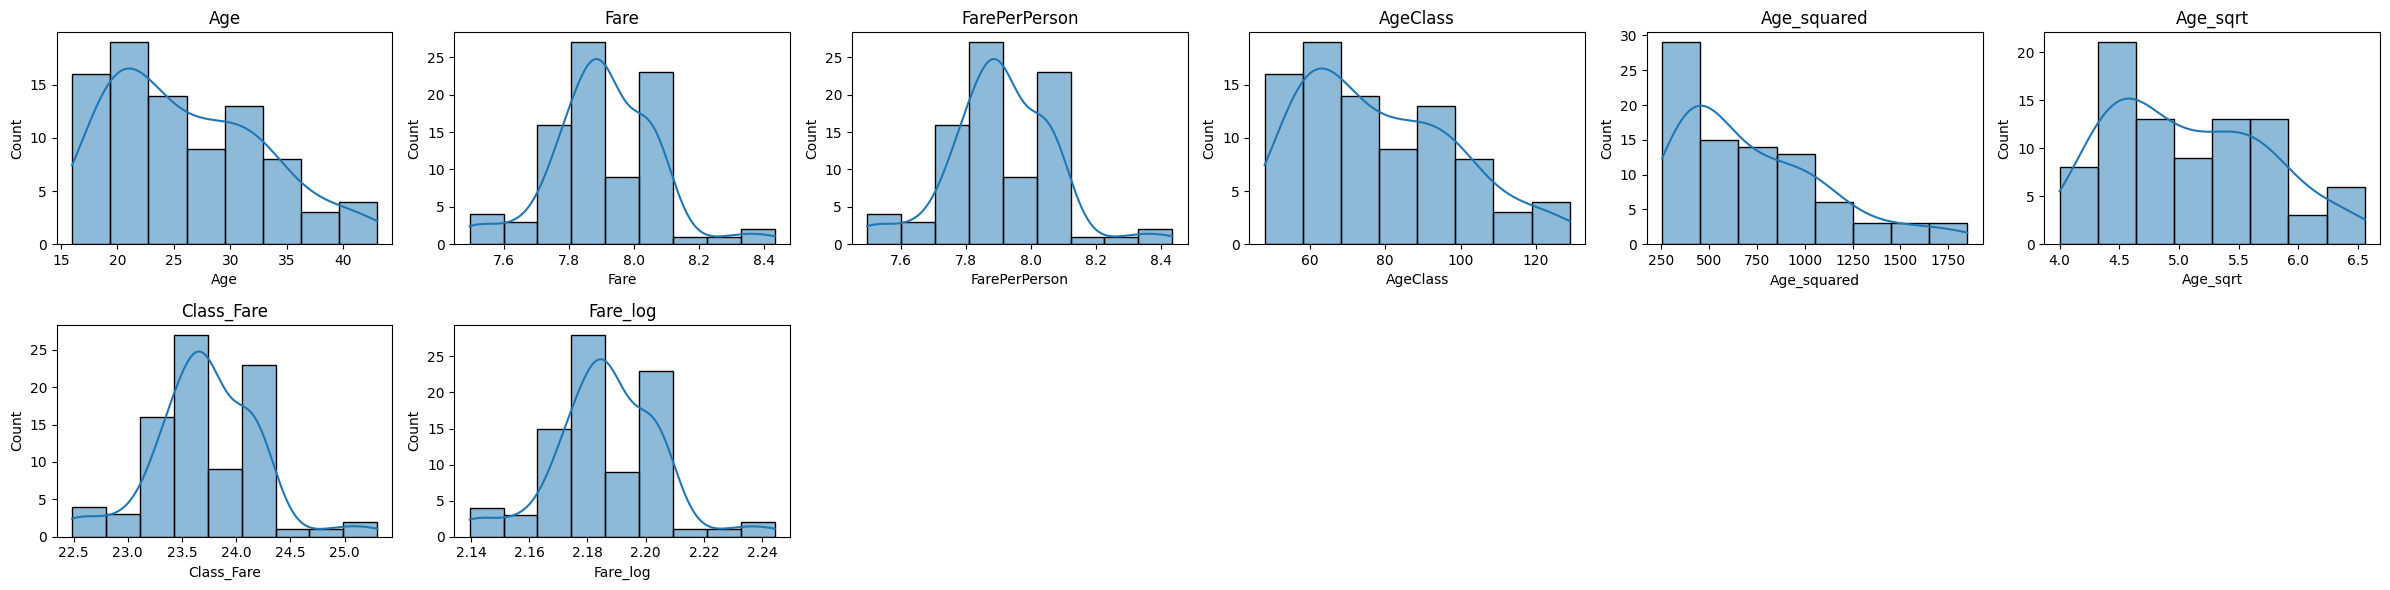

In [36]:
draw_hist(df_lin)

Пытаемся выровнять

In [37]:
df_numeric = df_lin.select_dtypes(include=['int64', 'float64'])
skew_values = df_numeric.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]
skew_values_hard.index

Index(['Survived', 'Age', 'AgeClass', 'Age_squared'], dtype='object')

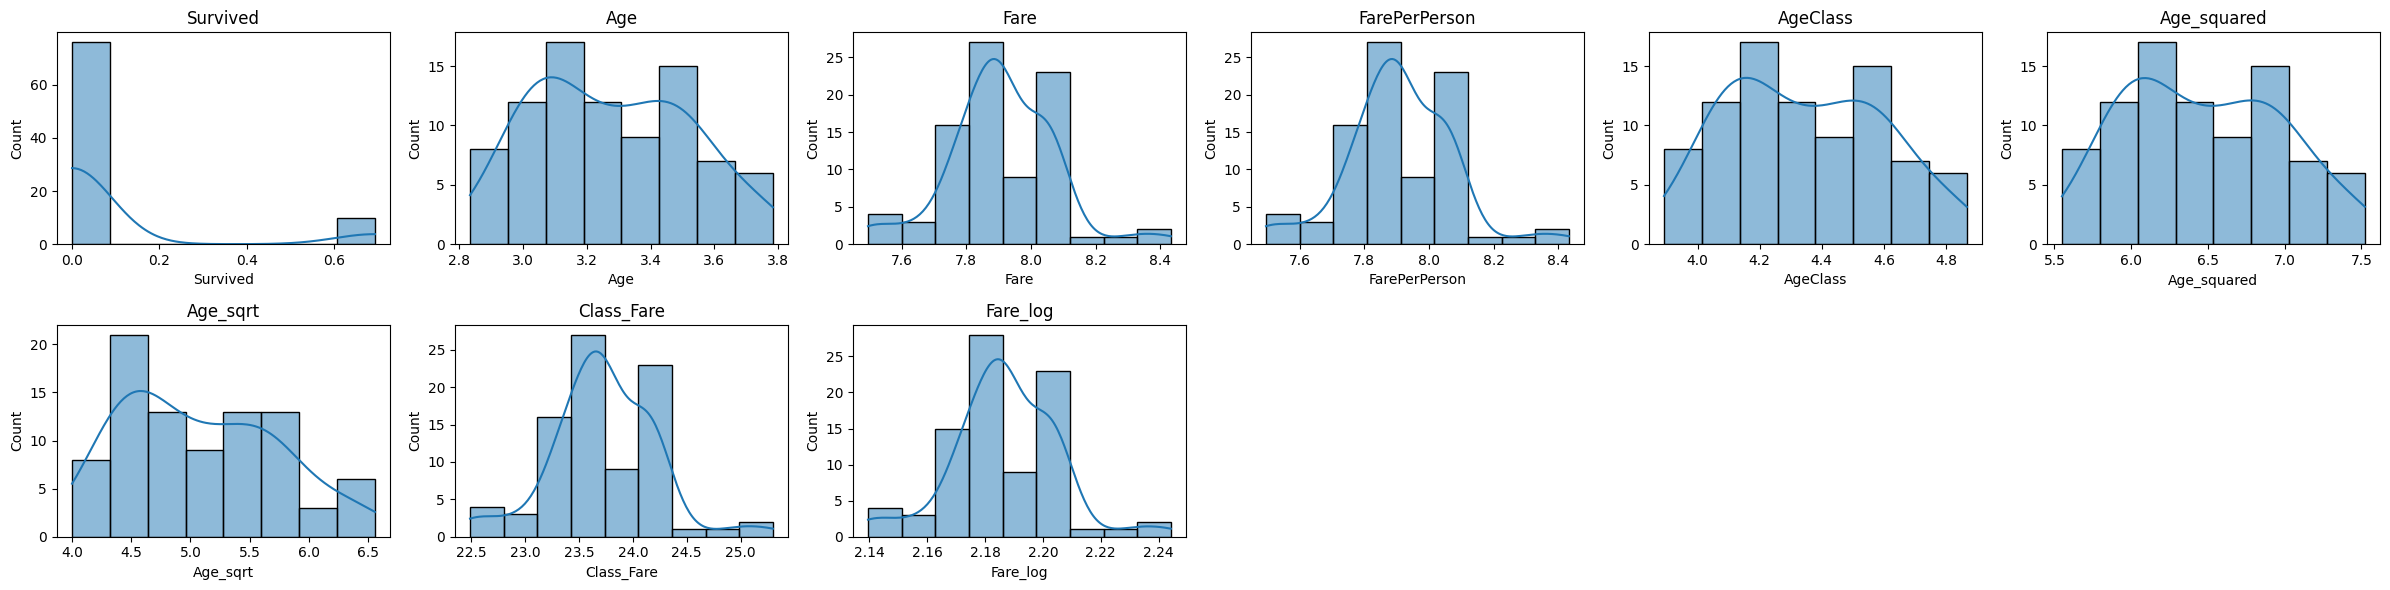

In [38]:
df_lin = prepare_skew(df = df_lin, columns = list(skew_values_hard.index))
draw_hist(df_lin)

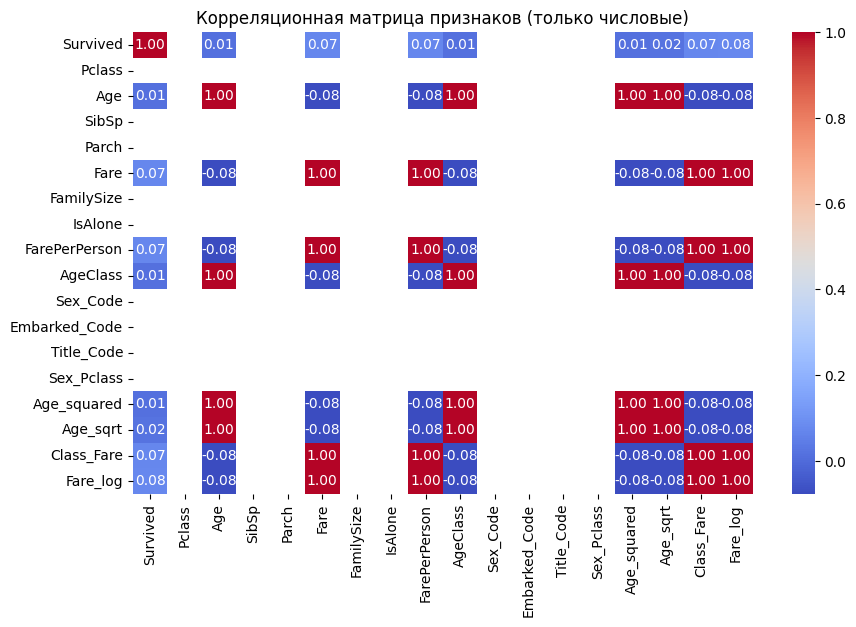

In [39]:
def draw_corr_matrix(df):
    df_num = df.select_dtypes(include=['int64', 'float64'])
    plt.figure(figsize=(10,6))
    sns.heatmap(df_num.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Корреляционная матрица признаков (только числовые)")
    plt.show()


draw_corr_matrix(df_lin)

### 2.4. Разделение вида Фичи - Таргет

Для: `SVM`, `Linear Binary Classification`, `KNN`

In [40]:
y_lin = df_lin['Survived']
X_lin = df_lin.drop('Survived', axis=1)
display(X_lin.head(3), y_lin.head(3))

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,FarePerPerson,AgeClass,Sex_Code,Embarked_Code,Title_Code,Sex_Pclass,Age_squared,Age_sqrt,Class_Fare,Fare_log
4,3,"Allen, Mr. William Henry",male,3.583519,0,0,373450,8.05,NaN,S,...,8.05,4.663439,1,2,2,3,7.111512,5.916080,24.15,2.202765
12,3,"Saundercock, Mr. William Henry",male,3.044522,0,0,A/5. 2151,8.05,NaN,S,...,8.05,4.110874,1,2,2,3,5.993961,4.472136,24.15,2.202765
37,3,"Cann, Mr. Ernest Charles",male,3.091042,0,0,A./5. 2152,8.05,NaN,S,...,8.05,4.158883,1,2,2,3,6.091310,4.582576,24.15,2.202765


,Survived
4,0.0
12,0.0
37,0.0


Для: `Desicion Tree`, `Random Forest` и `Gradient's Boosting Methods`

In [41]:
y = df_raw['Survived']
X = df_raw.drop('Survived', axis=1)
display(X.head(3), y.head(3))

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,FarePerPerson,AgeClass,Sex_Code,Embarked_Code,Title_Code,Sex_Pclass,Age_squared,Age_sqrt,Class_Fare,Fare_log
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,...,3.62500,66.0,1,2,2,3,484.0,4.690416,21.7500,2.110213
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,...,35.64165,38.0,0,0,3,0,1444.0,6.164414,71.2833,4.280593
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,...,7.92500,78.0,0,2,1,0,676.0,5.099020,23.7750,2.188856


,Survived
0,0
1,1
2,1


## 3. Создание моделей

### 3.0. Создание `SVM`, `Linear Binary Classification`, `KNN`

#### Support Vector Machine

[Почитать 1](https://scikit-learn.org/stable/modules/svm.html)

[Почитать 2](https://t.me/devwhoami/179)

Метод опорных векторов (Support Vector Machine, **SVM**) — это мощный и популярный алгоритм **линейной** (и нелинейной) **классификации**.

Основная идея:

1.  **Разделяющая гиперплоскость**: SVM находит оптимальную гиперплоскость (линию в 2D, плоскость в 3D), которая **наилучшим образом разделяет** классы в вашем наборе данных.
2.  **Максимизация зазора (Margin)**: "Наилучшим образом" означает, что гиперплоскость должна находиться на **максимальном расстоянии** от ближайших точек каждого класса. Это расстояние называется **зазором (margin)**.
3.  **Опорные векторы (Support Vectors)**: Только те точки данных, которые находятся **ближе всего** к гиперплоскости и определяют ширину зазора, называются **опорными векторами**. Эти точки имеют решающее значение; если их удалить, положение гиперплоскости может измениться.
4.  **Ядерный трюк (Kernel Trick)**: Для **нелинейно** разделимых данных SVM использует так называемый **ядерный трюк**. Он неявно проецирует данные в пространство более высокой размерности, где классы становятся линейно разделимыми, и находит там оптимальную гиперплоскость.

**Кратко**: SVM строит **широчайший возможный "коридор"** между классами, опираясь только на самые сложные (граничные) точки — опорные векторы.

In [42]:
from sklearn.svm import SVC

model_svm = SVC(
    C=1.0,           # Параметр регуляризации. Чем меньше C, тем шире зазор, тем больше ошибок допускается (сильнее регуляризация).
                     # Варианты: 0.1, 1, 10, 100.

    kernel='rbf',    # Тип ядра. Определяет, как данные будут проецироваться в пространство более высокой размерности.
                     # Варианты: 'linear' (линейный классификатор), 'poly' (полиномиальный),
                     # 'rbf' (Радиальная базисная функция - наиболее часто используется для нелинейных задач), 'sigmoid'.

    gamma='scale',   # Коэффициент ядра (для 'rbf', 'poly', 'sigmoid'). Определяет "влияние" одного обучающего примера.
                     # Варианты: 'scale' (1 / (n_features * X.var())) или 'auto' (1 / n_features) - рекомендуются по умолчанию.
                     # Или: небольшие значения (0.01, 0.1) для широкого влияния; большие значения (1, 10) для узкого влияния.

    degree=3,        # Степень полинома (для 'poly' ядра). Игнорируется для других ядер.
                     # Варианты: 2, 3, 4.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    probability=False # Включает оценку вероятности классов (медленнее, но иногда нужно).
                      # Варианты: True (если нужны предсказанные вероятности), False (по умолчанию, если нужна только классификация).
)


#### Logistic Regression

**Логистическая регрессия — краткое пояснение:**

Логистическая регрессия — это метод машинного обучения, используемый для решения задач **классификации**, то есть когда нужно предсказать, к какому классу принадлежит объект (например, «да/нет», «0/1»).

В отличие от линейной регрессии, логистическая регрессия предсказывает **вероятность принадлежности** объекта к определённому классу. Для этого используется **логистическая (сигмоидная) функция**, которая преобразует линейную комбинацию признаков в значение от 0 до 1.

Основные шаги:

1. Строится линейная модель:
    $$z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$$
2. К результату применяется сигмоида:
   $$p = \frac{1}{1 + e^{-z}}$$
3. Если ($p > 0.5$), то объект относят к классу 1, иначе — к классу 0.

Модель обучается с помощью **максимизации правдоподобия** (обычно через метод градиентного спуска).


In [43]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(
    penalty='l2',        # Тип регуляризации, добавляемой для предотвращения переобучения.
                         # 'l2' — стандартная (ридж-регуляризация), 'l1' — лассо-регуляризация (зануляет некоторые коэффициенты).
                         # Варианты: 'l1', 'l2', 'elasticnet', 'none'.

    C=1.0,               # Обратный коэффициент силы регуляризации.
                         # Чем меньше C — тем сильнее регуляризация (жестче штраф за большие коэффициенты).
                         # Варианты: 0.01, 0.1, 1, 10, 100.

    solver='lbfgs',      # Алгоритм оптимизации для нахождения весов модели.
                         # 'lbfgs' — универсальный и быстрый (подходит для малых и средних наборов данных).
                         # Другие варианты: 'liblinear' (поддерживает L1), 'saga' (работает с большими данными и L1/L2), 'newton-cg'.

    max_iter=100,        # Максимальное число итераций для сходимости алгоритма.
                         # Если обучение не сходится — увеличить, например до 500.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов (фиксирует начальные веса).

    fit_intercept=True,  # Добавляет свободный коэффициент (смещение) в модель.
                         # Обычно True, чтобы учитывать среднее значение признаков.

    n_jobs=None          # Количество потоков для параллельных вычислений.
                         # None — одно ядро, -1 — использовать все доступные ядра процессора.
)


#### K-Nearest Neighbors (KNN)

**Метод k-ближайших соседей — краткое пояснение:**

KNN (*k-nearest neighbors*) — это простой и интуитивный метод машинного обучения, применяемый для задач **классификации** и **регрессии**.
Он не строит явной модели — вместо этого принимает решение, основываясь на **схожести объектов** в пространстве признаков.

Идея метода:
Для нового объекта алгоритм ищет **k ближайших соседей** из обучающей выборки (по выбранной метрике расстояния) и определяет класс по **голосованию** этих соседей.

Основные шаги:

1. Выбирается число соседей $k$ — например, 3 или 5.
2. Для нового объекта вычисляются расстояния до всех объектов обучающей выборки.
3. Определяются $k$ ближайших точек.
4. Класс объекта определяется по большинству классов среди соседей.

Метод KNN **не имеет этапа обучения**, так как просто запоминает обучающие данные.
Основной параметр, влияющий на качество модели — это число соседей $k$:

* Малое $k$ делает модель чувствительной к шуму.
* Большое $k$ сглаживает границы между классами.


In [44]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(
    n_neighbors=5,      # Количество ближайших соседей (k).
                        # Малое значение делает модель чувствительной к шуму, большое — сглаживает предсказания.
                        # Варианты: 3, 5, 7, 9 и т.д.

    weights='uniform',  # Веса соседей при голосовании.
                        # 'uniform' — все соседи равны,
                        # 'distance' — соседи ближе к объекту имеют больший вес.

    metric='minkowski', # Метрика расстояния.
                        # По умолчанию 'minkowski' с p=2 соответствует евклидову расстоянию.
                        # Варианты: 'euclidean', 'manhattan', 'chebyshev', 'minkowski'.

    p=2,                # Степень метрики Минковского (p=1 — манхэттен, p=2 — евклид).
                        # Меняется только если выбран 'minkowski'.

    algorithm='auto',   # Алгоритм поиска ближайших соседей.
                        # 'auto' выбирает оптимальный метод (ball_tree, kd_tree, brute) в зависимости от данных.

    n_jobs=None         # Количество потоков для вычислений.
                        # None — одно ядро, -1 — использовать все доступные ядра процессора.
)

### 3.1. Создание `Desicion Tree`, `Random Forest`

#### Decision Tree Classifier (Дерево решений)

**Дерево решений — краткое пояснение:**

Дерево решений — это алгоритм **классификации и регрессии**, который принимает решения, разбивая данные по признакам в виде **дерева с узлами и ветвями**.
Каждый узел дерева соответствует условию на значение признака (например, «возраст > 30?»), а листья — это **предсказанные классы**.

Идея метода:
Алгоритм рекурсивно делит выборку на подмножества так, чтобы в каждом из них объекты как можно больше принадлежали одному классу.
Критерием “хорошего разбиения” служат меры **чистоты узла** — например, *Gini* или *энтропия*.

Основные шаги:

1. Выбирается признак и порог, которые лучше всего разделяют данные по целевой переменной.
2. Создаются новые ветви для каждого значения или диапазона признака.
3. Процесс повторяется до тех пор, пока не достигнуты условия остановки (например, максимальная глубина).
4. Листовые узлы содержат итоговые классы.

Преимущества:

* Простая интерпретация (можно визуализировать дерево).
* Не требует масштабирования данных.

Недостатки:

* Склонно к **переобучению**, особенно при большой глубине дерева.
* Может быть нестабильным (небольшие изменения данных → другое дерево).

In [45]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(
    criterion='gini',       # Критерий качества разбиения.
                            # 'gini' — индекс Джини (по умолчанию),
                            # 'entropy' — энтропия (информационный выигрыш),
                            # 'log_loss' — основан на логарифмической потере.

    splitter='best',        # Стратегия выбора признака для разбиения.
                            # 'best' — выбирает наилучшее разбиение,
                            # 'random' — выбирает случайный признак (для ускорения и разнообразия).

    max_depth=None,         # Максимальная глубина дерева.
                            # None — без ограничения (может привести к переобучению).
                            # Примеры: 3, 5, 10.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.
                            # Увеличение этого параметра уменьшает переобучение.

    min_samples_leaf=1,     # Минимальное количество образцов в листе.
                            # Увеличение значения делает дерево более “гладким”.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков, рассматриваемых при каждом разбиении.
                            # None — использовать все признаки.

    class_weight=None       # Веса классов для компенсации дисбаланса.
                            # Например: 'balanced' — автоматически выравнивает частоты классов.
)


#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [46]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(
    n_estimators=100,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='gini',        # Критерий качества разбиений для каждого дерева.
                             # 'gini' — индекс Джини (по умолчанию),
                             # 'entropy' — энтропия.

    max_depth=None,          # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=2,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=1,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features='sqrt',     # Количество признаков, используемых при поиске лучшего разбиения.
                             # 'sqrt' — стандарт для классификации (корень из числа признаков).
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    class_weight=None        # Веса классов для компенсации дисбаланса.
                             # 'balanced' — автоматически выравнивает частоты классов.
)

### 3.2. Создание `Gradient's Boosting Methods`

#### Gradient Boosting Classifier (Градиентный бустинг)

**Градиентный бустинг — краткое пояснение:**

Градиентный бустинг — это **ансамблевый метод**, который строит **последовательность слабых моделей** (обычно небольших деревьев решений), где каждая новая модель **исправляет ошибки предыдущих**.
В отличие от случайного леса, где деревья строятся **независимо**, в бустинге каждое следующее дерево обучается **на остатках (ошибках)** предыдущих.

Идея метода:

1. Обучается первое дерево, которое делает начальные предсказания.
2. Вычисляются ошибки (разница между предсказанными и истинными значениями).
3. Следующее дерево обучается предсказывать эти ошибки.
4. Итоговое предсказание — сумма (или взвешенная комбинация) всех деревьев.

Благодаря этому модель постепенно **минимизирует функцию потерь** и достигает высокой точности.

Преимущества:

* Очень высокая точность при правильной настройке.
* Хорошо работает с числовыми и категориальными признаками.
* Можно контролировать переобучение через глубину деревьев и скорость обучения.

Недостатки:

* Медленнее в обучении, чем случайный лес.
* Требует подбора гиперпараметров.
* Может переобучаться при слишком большом количестве деревьев.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(
    loss='log_loss',        # Функция потерь, которую минимизирует алгоритм.
                            # 'log_loss' — для классификации (по умолчанию),
                            # 'exponential' — аналог AdaBoost.

    learning_rate=0.1,      # Скорость обучения (вклад каждого дерева в общий результат).
                            # Меньшие значения (0.01–0.1) делают обучение стабильнее, но требуют больше деревьев.

    n_estimators=100,       # Количество слабых моделей (деревьев).
                            # Большее число может повысить точность, но и риск переобучения.

    subsample=1.0,          # Доля выборки, используемая для обучения каждого дерева.
                            # Значения < 1.0 добавляют стохастичность (ускоряют и уменьшают переобучение).

    criterion='friedman_mse', # Критерий качества разбиений.
                              # 'friedman_mse' — оптимальный для бустинга,
                              # 'squared_error' и 'mse' — классические варианты.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.

    min_samples_leaf=1,     # Минимальное число образцов в листе.

    max_depth=3,            # Максимальная глубина базовых деревьев.
                            # Малые значения (3–5) обычно предотвращают переобучение.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков при разбиении.
                            # None — использовать все признаки, 'sqrt' или 'log2' — случайное подмножество.

    verbose=0               # Если >0, выводит процесс обучения (для отладки).
)


#### XGBoost (Extreme Gradient Boosting)

**XGBoost — краткое пояснение:**

**XGBoost (Extreme Gradient Boosting)** — это усовершенствованная реализация градиентного бустинга, созданная для **скорости, эффективности и точности**.
Он работает по тем же принципам, что и обычный **Gradient Boosting**, но добавляет оптимизации на уровне вычислений, регуляризации и обработки пропусков.

XGBoost строит ансамбль из множества **деревьев решений**, каждое из которых **исправляет ошибки предыдущих**, минимизируя функцию потерь с помощью **градиентного спуска**.

Особенности XGBoost:

* Использует **L1 и L2 регуляризацию**, что снижает переобучение.
* Поддерживает **параллельное обучение** деревьев.
* Эффективно работает с **пропущенными данными**.
* Может применяться не только для классификации, но и для регрессии, ранжирования и др.

Преимущества:

* Очень высокая точность.
* Быстрее классического `GradientBoostingClassifier`.
* Гибкость — множество гиперпараметров для точной настройки.

Недостатки:

* Сложнее в настройке.
* Требует больше памяти и вычислительных ресурсов.


In [48]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,        # Количество деревьев (итераций бустинга).
                            # Увеличение может повысить качество, но и риск переобучения.

    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева).
                            # Меньшие значения (0.01–0.1) требуют большего числа деревьев.

    max_depth=3,             # Максимальная глубина деревьев.
                            # Контролирует сложность модели — большее значение → выше риск переобучения.

    subsample=1.0,           # Доля выборки, используемая при построении каждого дерева.
                            # Меньше 1.0 → случайность и снижение переобучения.

    colsample_bytree=1.0,    # Доля признаков, выбираемых при построении каждого дерева.
                            # Обычно 0.8–1.0 — для ускорения и устойчивости.

    gamma=0,                 # Минимальное улучшение функции потерь для разбиения узла.
                            # Увеличение gamma делает модель более консервативной.

    reg_alpha=0,             # L1-регуляризация (на коэффициенты).
                            # Увеличение помогает убрать незначимые признаки.

    reg_lambda=1,            # L2-регуляризация (по умолчанию).
                            # Контролирует переобучение через штраф на большие веса.

    objective='binary:logistic', # Функция потерь.
                                 # 'binary:logistic' — для бинарной классификации (0/1),
                                 # 'multi:softmax' — для многоклассовой (требует num_class).

    random_state=RANDOM_STATE,   # Для воспроизводимости результатов.

    n_jobs=-1,              # Использовать все ядра процессора для ускорения обучения.

    verbosity=0             # Уровень вывода (0 — без вывода, 1–3 — подробные логи).
)

#### CatBoost Classifier (Categorical Boosting, от Яндекса)

**CatBoost** — это современный алгоритм **градиентного бустинга**, разработанный компанией **Яндекс**.
Название расшифровывается как *“Categorical Boosting”*, поскольку он изначально создан для **работы с категориальными признаками** — без необходимости их кодировать вручную (в отличие от XGBoost или LightGBM).

CatBoost строит ансамбль **решающих деревьев**, где каждое следующее дерево **исправляет ошибки предыдущих**, используя метод **градиентного спуска**.
Главная особенность — **эффективная обработка категориальных данных** и **устойчивость к переобучению**.

**Особенности CatBoost:**

* Автоматически кодирует категориальные признаки (*“target encoding with permutations”*).
* Использует **симметричные деревья** (каждое разбиение делается одинаково по всем ветвям), что ускоряет предсказания.
* Встроенная **регуляризация** и **устойчивость к переобучению**.
* Поддерживает **GPU-ускорение** и многопоточность.

**Преимущества:**

* Работает “из коробки” без сложной подготовки данных.
* Часто требует меньше настройки гиперпараметров.
* Высокая точность и скорость обучения.

**Недостатки:**

* Более “тяжёлый” по памяти, чем простые модели.
* Для очень больших данных может быть медленнее LightGBM.


In [49]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=1000,         # Количество деревьев (итераций бустинга).
                             # Увеличение может повысить точность, но и время обучения.

    learning_rate=0.1,       # Скорость обучения.
                             # Малые значения (0.01–0.1) делают обучение стабильнее, но дольше.

    depth=6,                 # Глубина деревьев.
                             # Контролирует сложность модели (типично 4–10).

    loss_function='Logloss', # Функция потерь (для бинарной классификации).
                             # 'Logloss' — бинарная, 'MultiClass' — многоклассовая.

    l2_leaf_reg=3.0,         # Коэффициент L2-регуляризации.
                             # Повышение снижает переобучение.

    random_seed=RANDOM_STATE, # Для воспроизводимости.

    bootstrap_type='Bayesian', # Метод подвыборки данных при обучении.
                               # 'Bayesian' — по умолчанию, 'Bernoulli', 'MVS' — альтернативы.

    # subsample=0.8,           # Доля данных, используемая для каждого дерева.
                             # Меньше 1.0 — для стохастичности и борьбы с переобучением.

    verbose=0,             # Как часто выводить прогресс обучения (итерации).
                             # 0 — без вывода.

    cat_features=None,       # Список индексов категориальных признаков.
                             # Можно не указывать, если CatBoost сам их определяет.

    task_type='CPU'          # Тип устройства для обучения: 'CPU' или 'GPU'.
)

## 4. Обучение и прогонка

Реализуем пайплайн тестирования

In [50]:
# Функция для вычисления метрик
def evaluate_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    if y_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    return metrics

In [51]:
def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [52]:
def test_models_pipeline(df, target_col, models_dict, n_splits=5, random_state=RANDOM_STATE):
    """
    Пайплайн тестирования моделей с Cross-Validation, метриками, визуализацией разделяющей поверхности и ROC-AUC.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        models_dict : dict
            Словарь моделей в формате {"ModelName": model_instance}.
        n_splits : int
            Количество фолдов для Stratified K-Fold CV.
        random_state : int
            Для воспроизводимости.
    """

    X = df.drop(columns=target_col).values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, model in models_dict.items():
        acc_list, f1_list, roc_list = [], [], []

        for train_idx, test_idx in kf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_proba = None
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_proba = model.decision_function(X_test)

            metrics = evaluate_metrics(y_test, y_pred, y_proba)
            acc_list.append(metrics['accuracy'])
            f1_list.append(metrics['f1'])
            if 'roc_auc' in metrics:
                roc_list.append(metrics['roc_auc'])

        # Вывод метрик
        print(f"=== {name} ===")
        print(f"Accuracy: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
        print(f"F1-score: {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")
        if roc_list:
            print(f"ROC-AUC: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")

In [81]:
from sklearn.impute import SimpleImputer

In [82]:
def plot_fixed_feature_decision_surface(df, target_col, model, fixed_feature, feature_names=None, n_cols=3, impute_strategy='mean'):
    """
    Строит scatterplot с разделяющей поверхностью для фиксированного признака против всех остальных.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        model : sklearn estimator
            Обученная модель классификации.
        fixed_feature : str
            Название признака, который будет "фиксированным".
        feature_names : list or None
            Список признаков. Если None, берутся все колонки кроме target.
        n_cols : int
            Количество графиков на строку.
        impute_strategy : str, optional
            Стратегия импутации NaN: 'mean' (среднее) или 'median' (медиана). По умолчанию 'mean'.
    """

    if feature_names is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        feature_names = [c for c in numeric_cols if c != target_col]

    if fixed_feature not in feature_names:
        raise ValueError(f"{fixed_feature} not found in numeric features")

    X = df[feature_names].values
    y = df[target_col].values

    imputer = SimpleImputer(strategy=impute_strategy)
    X_imputed = imputer.fit_transform(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    fixed_idx = feature_names.index(fixed_feature)
    other_indices = [i for i in range(len(feature_names)) if i != fixed_idx]

    n_plots = len(other_indices)
    if n_plots == 0:
        print("No other numeric features to plot against the fixed feature.")
        return

    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for k, j in enumerate(other_indices):
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_scaled[:, [fixed_idx, j]], y)

        x_min, x_max = X_scaled[:, fixed_idx].min() - 1, X_scaled[:, fixed_idx].max() + 1
        y_min, y_max = X_scaled[:, j].min() - 1, X_scaled[:, j].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))

        Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = axes[k]
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        scatter = ax.scatter(X_scaled[:,fixed_idx], X_scaled[:,j], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
        ax.set_xlabel(fixed_feature)
        ax.set_ylabel(feature_names[j])
        ax.set_title(f"{model.__class__.__name__}: {fixed_feature} vs {feature_names[j]}")

    # Если графиков меньше, чем ячеек subplots
    for m in range(k + 1, len(axes)):
        fig.delaxes(axes[m])

    plt.tight_layout()
    plt.show()

### 4.0 Обучение и тесты моделей \{SVM, Logistic Regression, KNN, Desicion Tree, Random Forest\}

In [54]:
df_lin = df_lin.dropna(subset=['Survived'])
df_lin['Survived'].value_counts(dropna=False)
df_lin['Survived'] = df_lin['Survived'].astype(int)


In [89]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

def test_models_pipeline(df, target_col, models_dict, n_splits=5, random_state=42):
    # 1. Отделяем X / y
    df = df.copy()
    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col])

    # 2. Удаляем малоинформативные текстовые фичи
    drop_cols = ['Name', 'Ticket', 'Cabin']
    X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')

    # 3. Разделяем типы признаков
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # 5. KFold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Таблица с результатами
    results = []

    for model_name, model in models_dict.items():
        fold = 1
        fold_metrics = []

        print(f"\n===== Модель: {model_name} ====")

        for train_idx, test_idx in kf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # 4. Pipeline предобработки - NOW WITH IMPUTERS
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                    ]), numeric_cols),
                    ('cat', Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'))
                    ]), categorical_cols)
                ]
            )

            # 6. Финальный pipeline (предобработка + модель)
            clf = Pipeline(steps=[
                ("preprocess", preprocessor),
                ("model", model)
            ])

            # 7. Обучение
            clf.fit(X_train, y_train)

            # 8. Предсказание
            y_pred = clf.predict(X_test)

            # 9. Метрики
            acc = accuracy_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            fold_metrics.append([acc, prec, rec, f1])

            print(f"Fold {fold}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
            fold += 1

        # сохраняем средние по фолдам
        fold_metrics = np.array(fold_metrics)
        results.append([
            model_name,
            fold_metrics[:,0].mean(),
            fold_metrics[:,1].mean(),
            fold_metrics[:,2].mean(),
            fold_metrics[:,3].mean(),
        ])

    # 10. Возвращаем таблицу
    return pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])


In [61]:
df_lin['Survived'].value_counts(dropna=False)
df_lin = df_lin.dropna(subset=['Survived'])


In [77]:
df_lin = df_raw.copy()

models = {
    "SVM": model_svm,
    "LogReg": model_logreg,
    "KNN": model_knn,
    "DecisionTree": model_tree,
    "RandomForest": model_forest,
    "GradientBoosting": model_gb
}

results = test_models_pipeline(df_lin, target_col='Survived', models_dict=models)
results


===== Модель: SVM ====
Fold 1: acc=0.838, prec=0.812, rec=0.754, f1=0.782
Fold 2: acc=0.820, prec=0.790, rec=0.721, f1=0.754
Fold 3: acc=0.820, prec=0.821, rec=0.676, f1=0.742
Fold 4: acc=0.837, prec=0.820, rec=0.735, f1=0.775
Fold 5: acc=0.865, prec=0.857, rec=0.783, f1=0.818

===== Модель: LogReg ====
Fold 1: acc=0.832, prec=0.820, rec=0.725, f1=0.769
Fold 2: acc=0.826, prec=0.814, rec=0.706, f1=0.756
Fold 3: acc=0.831, prec=0.839, rec=0.691, f1=0.758
Fold 4: acc=0.837, prec=0.820, rec=0.735, f1=0.775
Fold 5: acc=0.848, prec=0.839, rec=0.754, f1=0.794

===== Модель: KNN ====
Fold 1: acc=0.832, prec=0.820, rec=0.725, f1=0.769
Fold 2: acc=0.803, prec=0.720, rec=0.794, f1=0.755
Fold 3: acc=0.787, prec=0.778, rec=0.618, f1=0.689
Fold 4: acc=0.837, prec=0.831, rec=0.721, f1=0.772
Fold 5: acc=0.831, prec=0.810, rec=0.739, f1=0.773

===== Модель: DecisionTree ====
Fold 1: acc=0.827, prec=0.806, rec=0.725, f1=0.763
Fold 2: acc=0.798, prec=0.716, rec=0.779, f1=0.746
Fold 3: acc=0.764, prec=0

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.836137,0.820213,0.733717,0.774222
1,LogReg,0.835020,0.826180,0.722123,0.770458
2,KNN,0.818166,0.791496,0.719224,0.751476
3,DecisionTree,0.792329,0.729368,0.733930,0.730769
4,RandomForest,0.830519,0.792301,0.757204,0.774067
5,GradientBoosting,0.831636,0.810601,0.733717,0.769615


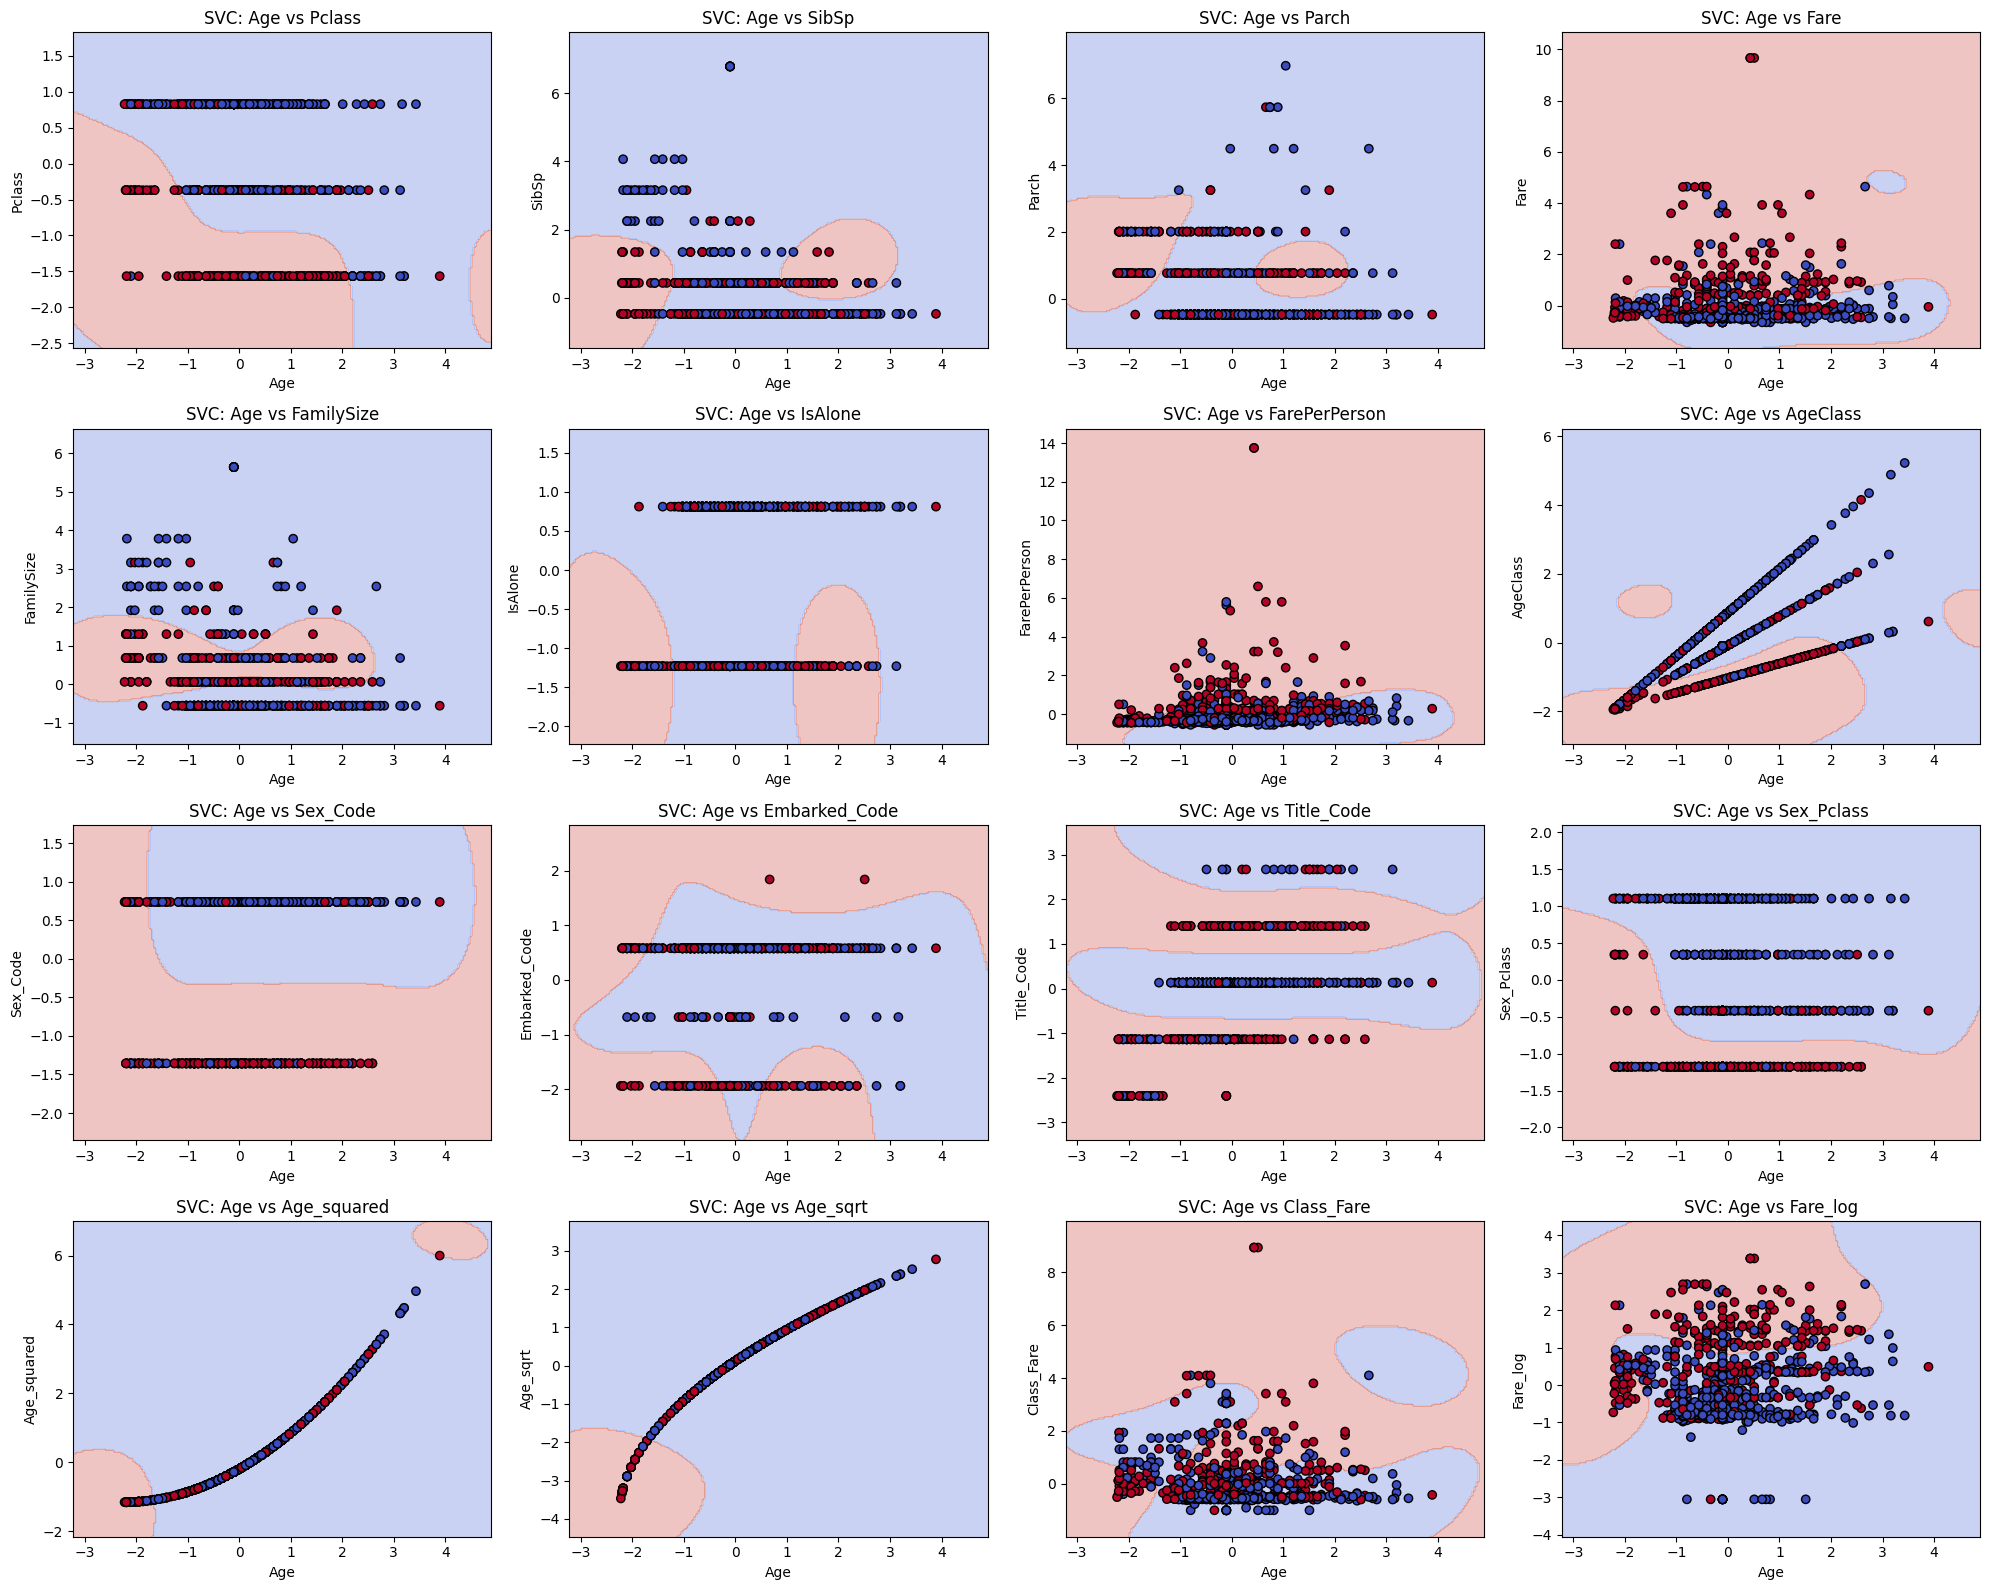

In [83]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Survived',
    model=model_svm,
    fixed_feature='Age',
    n_cols=4,
    impute_strategy='median'
)

### 4.2 Обучение и тесты моделей \{Boosting Classifier, XGBoost, CatBoost\}

In [85]:
# Список моделей
models = {
    "Boosting": model_gb,
    "XGBoost": model_xgb,
    "CatBoost": model_cat
}

test_models_pipeline(df_raw, target_col='Survived', models_dict=models, n_splits=5, random_state=RANDOM_STATE)


===== Модель: Boosting ====
Fold 1: acc=0.844, prec=0.825, rec=0.754, f1=0.788
Fold 2: acc=0.803, prec=0.754, rec=0.721, f1=0.737
Fold 3: acc=0.826, prec=0.836, rec=0.676, f1=0.748
Fold 4: acc=0.826, prec=0.794, rec=0.735, f1=0.763
Fold 5: acc=0.860, prec=0.844, rec=0.783, f1=0.812

===== Модель: XGBoost ====
Fold 1: acc=0.860, prec=0.867, rec=0.754, f1=0.806
Fold 2: acc=0.843, prec=0.794, rec=0.794, f1=0.794
Fold 3: acc=0.826, prec=0.836, rec=0.676, f1=0.748
Fold 4: acc=0.815, prec=0.769, rec=0.735, f1=0.752
Fold 5: acc=0.837, prec=0.812, rec=0.754, f1=0.782

===== Модель: CatBoost ====
Fold 1: acc=0.821, prec=0.785, rec=0.739, f1=0.761
Fold 2: acc=0.831, prec=0.764, rec=0.809, f1=0.786
Fold 3: acc=0.809, prec=0.774, rec=0.706, f1=0.738
Fold 4: acc=0.820, prec=0.773, rec=0.750, f1=0.761
Fold 5: acc=0.843, prec=0.806, rec=0.783, f1=0.794


,Model,Accuracy,Precision,Recall,F1
0,Boosting,0.831636,0.810601,0.733717,0.769615
1,XGBoost,0.836112,0.815776,0.742626,0.776424
2,CatBoost,0.824920,0.780279,0.757289,0.768136


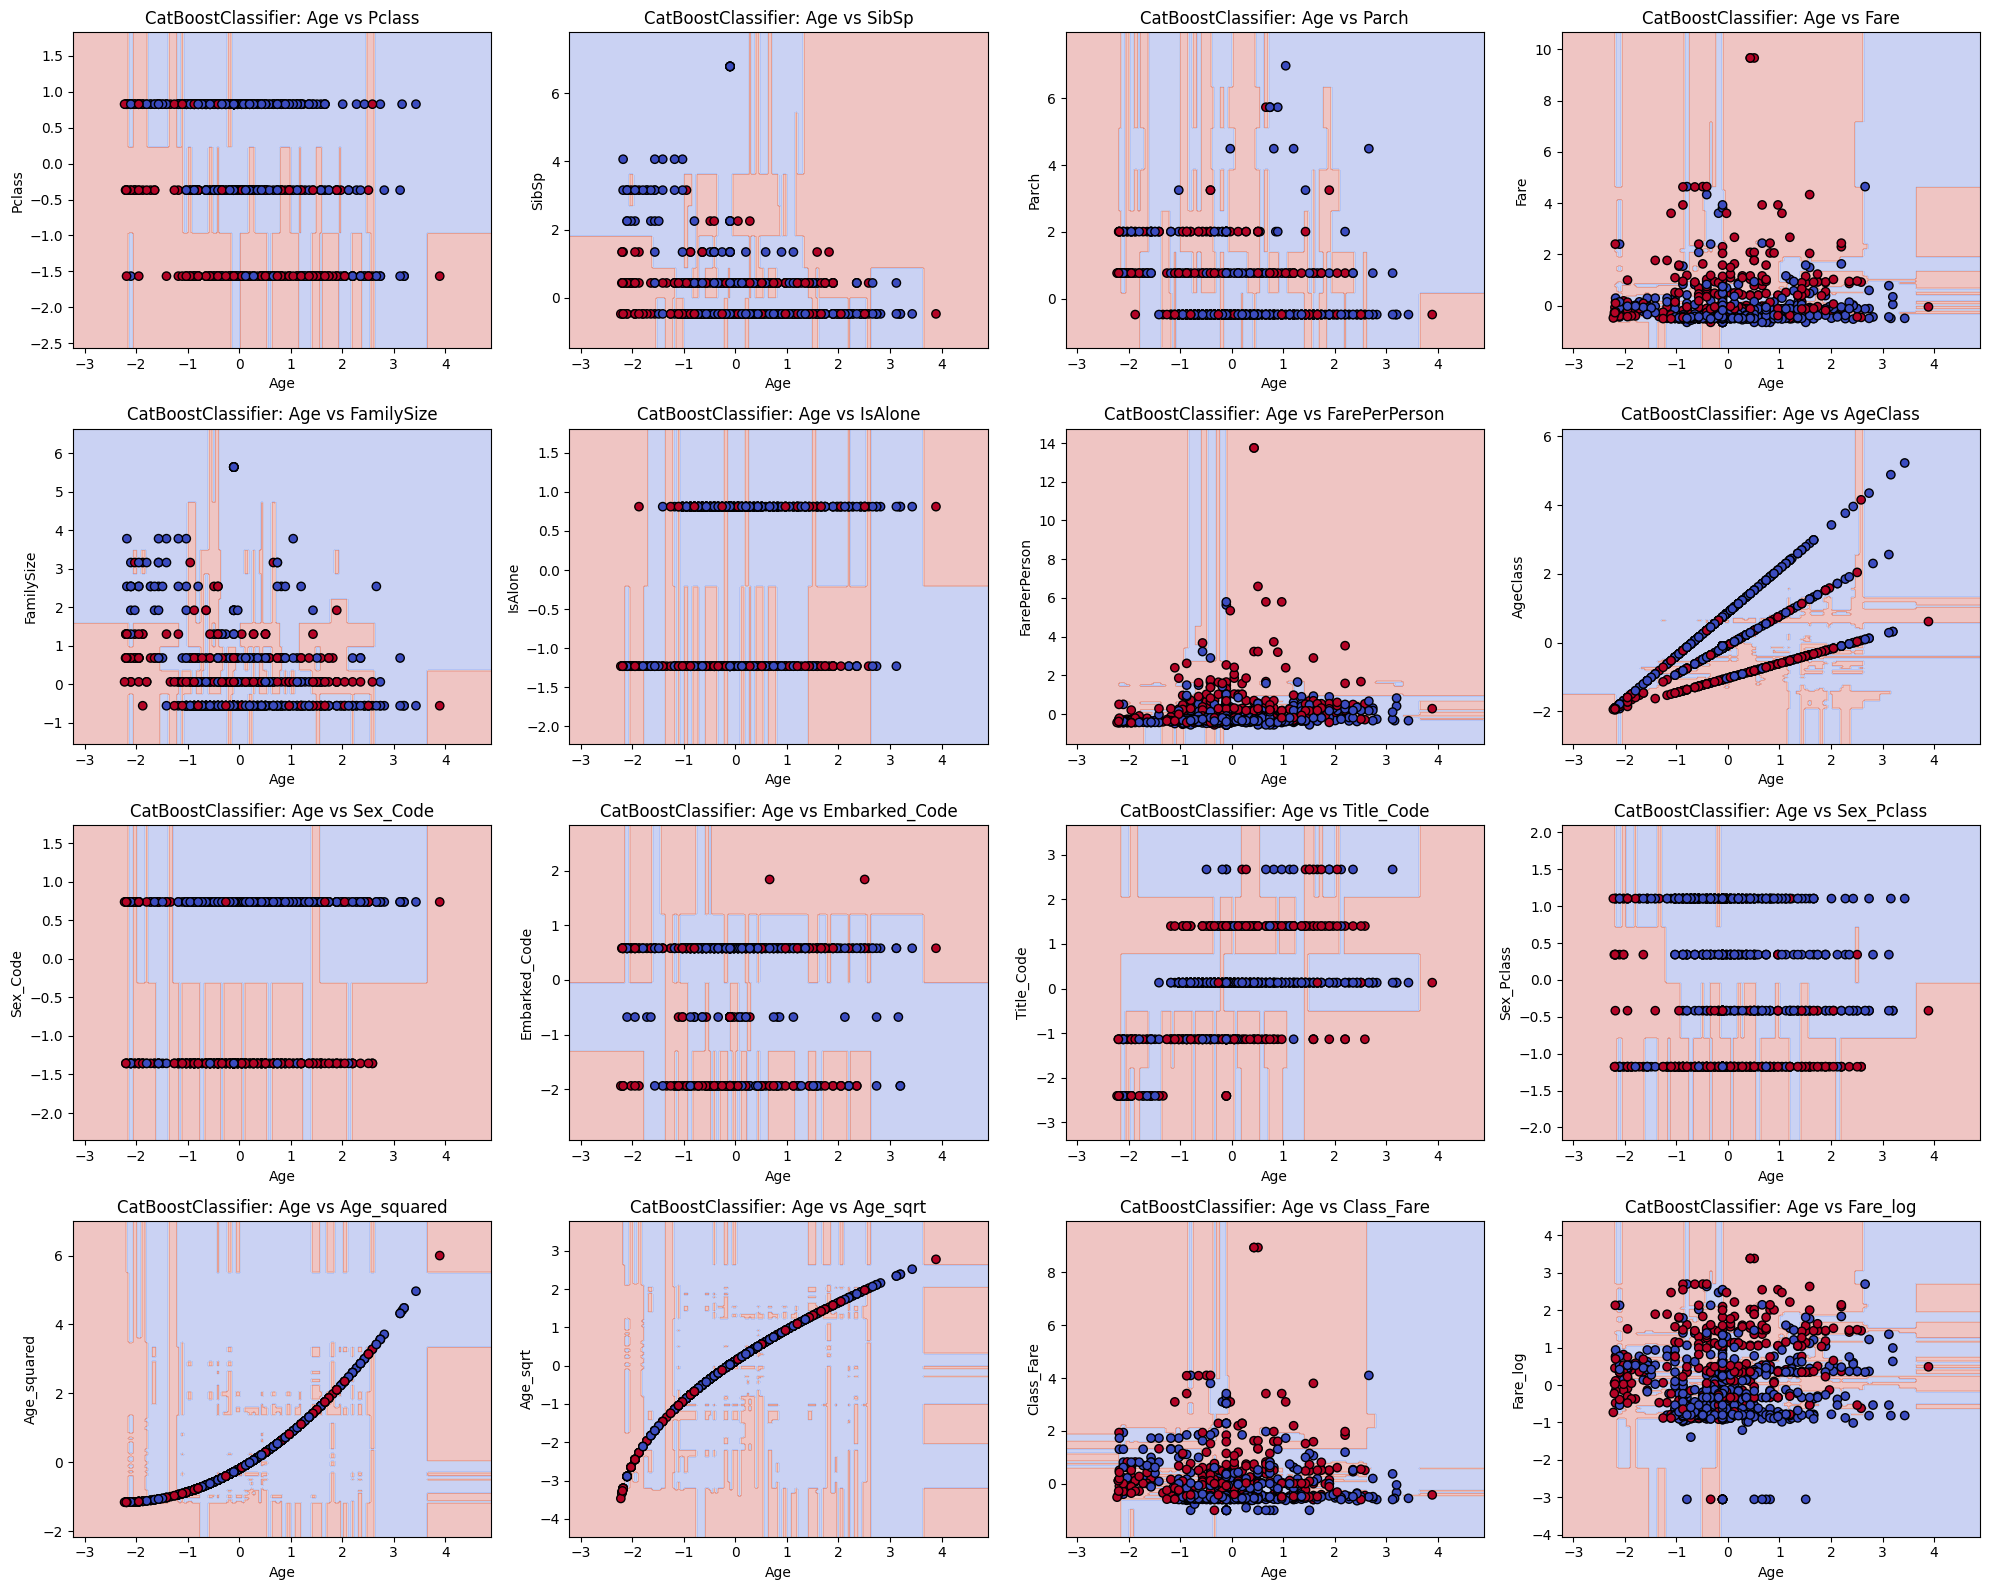

In [88]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Survived',
    model=model_cat,
    fixed_feature='Age',
    n_cols=4,
    impute_strategy='median'
)

## 5. Вопросы

**1. Классификация писем: спам или не спам**

**Вопрос:**
У нас есть набор писем, для каждого известны признаки:

* количество восклицательных знаков,
* доля заглавных букв,
* наличие слов вроде “free”, “win”, “discount”,
* длина письма,
* наличие ссылок.

Задача — определить, является ли письмо **спамом** или **нормальным**.

**Распределение данных:**

* Данные нелинейно разделимы, но умеренно шумные.
* Классы примерно сбалансированы (50/50).

**Ответ:**

- **Модель:**

```
SVM
```

- **Почему:**

```
SVM будет эффективнее для меньшего числа признаков (здесь 5–6), так как требует меньше данных для обучения и интерпретируется проще
```

**2. Прогноз сердечных заболеваний**

**Вопрос:**
Данные о пациентах:

* возраст, пол, давление, уровень холестерина, частота сердечных сокращений,
* наличие боли в груди и др.

Задача — определить, есть ли у человека сердечное заболевание.

**Распределение данных:**

* Классы умеренно сбалансированы (60/40).
* Признаки имеют нелинейные зависимости.

**Ответ:**

- **Модель:**

```
Random Forest
```

- **Почему:**

```
Random Forest хорошо справляется с нелинейными зависимостями между признаками (возраст, холестерин, давление часто взаимодействуют нелинейно, например, риск растёт экспоненциально после определённого порога), строя ансамбль деревьев решений, которые захватывают взаимодействия без явного feature engineering
```

**3. Распознавание видов ирисов (Iris dataset)**

**Вопрос:**
По измерениям длины и ширины лепестков и чашелистиков нужно определить вид ириса:
`setosa`, `versicolor` или `virginica`.

**Распределение данных:**

* Данные чистые, малошумные.
* Классы хорошо разделяются в пространстве признаков.

**Ответ:**

- **Модель:**

```
Logistic Regression
```

- **Почему:**

```
Iris — классический датасет с чистыми, малошумными данными и хорошо разделимыми классами.Logistic Regression эффективны для линейно разделимых задач: они предполагают линейные границы и минимизируют внутриклассовую дисперсию, достигая почти идеальной точности на таких данных без переобучения
```

**6. Классификация отзывов о фильмах (положительный / отрицательный)**

**Вопрос:**
Для каждого отзыва по фильму дан текст. Нужно определить, положительный он или отрицательный.
Используются текстовые признаки — мешок слов (TF-IDF).

**Распределение данных:**

* Очень высокое число признаков (10k+ слов).
* Данные разреженные.

**Ответ:**

- **Модель:**

```
Logistic Regression
```

- **Почему:**

```
Для высокоразмерных и разреженных данных Logistic Regression — стандартный выбор: она линейна, но эффективна в high-dimensional sparse пространствах, быстро обучается (O(n_features * n_samples)) и устойчивa к коллинеарности
```
